### Notebook to plot longwave feedback and associated variables from WRF model output.

James Ruppert  
jruppert@ou.edu  
2/15/24

In [2]:
import numpy as np
import matplotlib
from matplotlib import ticker
import matplotlib.pyplot as plt
import sys
from thermo_functions import *
from precip_class import *
import seaborn as sns
# import xarray as xr
from memory_usage import *
from read_functions import *
import pickle
import os.path
# import cartopy

### Main settings

In [3]:
# #### Main settings

storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
datdir2 = 'post/d02/'
main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'
figdir = "/home/jamesrup/figures/tc/ens/boxplot/"

# Set to true to do sensitivty test comparisons
# Else: analysis of CTL only
do_tests=True
# do_tests=False
t1_test=12 # n time steps to sample for tests
# t1_test=2 # n time steps to sample for tests

# Read and write variables, or load in saved pickle?
# do_write=True
do_write=False

pickle_file = main_pickle+'lw_feedback_'+str(t1_test)+'hrs.pkl'
if not do_write:
    if not os.path.isfile(pickle_file):
        raise Exception('Pickle file not found!')

time_neglect=12 # time steps from start to neglect

# Number of sample time steps (if only running CTL)
nt=200 # will be chopped down to max available
# nt=48
# nt=12

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 3
enstag = str(nmem)

In [4]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
test_str='ctl'
datdir = main+storm+'/'+memb_all[0]+'/'+test_str+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
dp = (pres[1]-pres[0])*1e2 # Pa
nt=np.min([nt,nt_data-time_neglect])
if do_tests:
    nt=t1_test
nx1-=80*2
nx2-=80*2

In [5]:
# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h','STRATANVIL_ON','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','NCRF','STRATANVON','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']

if not do_tests:
    tests=[tests[0]]
    tests_str=[tests_str[0]]
ntest = len(tests)

### Read loop

In [6]:
# Main read loops for 3D (dependent) variables

if do_write:

    # Arrays to save variables
    dims = (ntest, nmem, nt, nx1, nx2)
    pclass_all = np.ma.zeros(dims)
    cwv_1hr    = np.ma.zeros(dims)
    lwacre_1hr = np.ma.zeros(dims)
    qrain_1hr  = np.ma.zeros(dims)
    rain_1hr   = np.ma.zeros(dims)
    vmf_1hr    = np.ma.zeros(dims)

    for itest in range(ntest):
    # for itest in range(1):

        test_str = tests[itest]
        print()
        print('Running test: ',test_str)

        # t0=time_neglect # neglect the first 12 time steps
        # t1=t0+nt
        if test_str == 'ctl':
            t0=time_neglect
            t1=nt+t0
            if do_tests:
                t0=36
                # t1=t0+49
                # Control test time sample
                t1=t0+t1_test
        else:
            t0=0
            # t1=49 # max
            # Control test time sample
            t1=t1_test

        # Loop over ensemble members
        for imemb in range(nmem):
        # for imemb in range(1):

            print('Running imemb: ',memb_all[imemb])

            datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2
            print(datdir)

            # Stratiform ID
            q_int = read_qcloud(datdir,t0,t1,mask=True,drop=True) # mm
            pclass = precip_class(q_int)

            # CWV
            varname='PW'
            cwv = var_read_2d(datdir,varname,t0,t1,mask=True,drop=True) # mm
            # ddtq = np.gradient(lwnet, axis=0) # mm/hr

            # Rain rate
            varname = 'rainrate'
            rain = var_read_2d(datdir,varname,t0,t1,mask=True,drop=True) # mm/d

            # LWACRE
            lwacre = read_lwacre(datdir,t0,t1,mask=True,drop=True) # W/m2

            # Vertical motion
            # plev_read=850 # hPa
            # ik_tag='850'
            # ik = (pres == plev_read).nonzero()[0][0]
            # w = var_read_3d_ik(datdir, 'W', t0, t1, ik, mask=True, drop=True) # m/s
            vmf = read_mse_diag(datdir, 'vmf', t0, t1, mask=True, drop=True) # kg/m/s

            # Save variables for each ens member
            pclass_all[itest,imemb,:,:,:] = pclass
            rain_1hr[itest,imemb,:,:,:]   = rain
            qrain_1hr[itest,imemb,:,:,:]  = q_int[1]
            cwv_1hr[itest,imemb,:,:,:]    = cwv
            lwacre_1hr[itest,imemb,:,:,:] = lwacre
            vmf_1hr[itest,imemb,:,:,:]    = vmf

### Analysis code

In [7]:
# Smoothing function
# def time_smooth_var(var, nwindow):
#     data_xr = xr.DataArray(var,
#                             coords={'test':np.arange(ntest), 'memb':memb_nums, 'time':np.arange(nt),
#                             'y':np.arange(nx1), 'x':np.arange(nx2)},
#                             dims=['test','memb','time','y','x'])
#     data_smooth = data_xr.rolling(time=nwindow, center=True).mean()
#     return data_smooth.to_masked_array()

In [8]:
# # ### Run binning

# def get_kstrat_cells(var_in, strat):
#     var_indexed = []
#     nstrat=6
#     for kstrat in range(nstrat):
#         indices = (strat == kstrat).nonzero()
#         indexed_var = var_in[indices[0],indices[1],indices[2],indices[3]]
#         var_indexed.append(indexed_var)
#     return var_indexed

In [9]:
# qrain_indexed_1hr    = get_kstrat_cells(qrain_1hr, strat_all)
# cwv_indexed_1hr      = get_kstrat_cells(cwv_1hr, strat_all)
# lwacre_indexed_1hr   = get_kstrat_cells(lwacre_1hr, strat_all)
# # vmfu_indexed_1hr     = get_kstrat_cells(vmfu_1hr, strat_all)
# # condh_indexed_1hr    = get_kstrat_cells(condh_1hr, strat_all)
# lwfeedb1_indexed_1hr = get_kstrat_cells(np.absolute(lwacre_1hr)/qrain_1hr, strat_all)
# # lwfeedb2_indexed_1hr = get_kstrat_cells(np.absolute(lwacre_1hr)/vmfu_1hr , strat_all)
# # lwfeedb3_indexed_1hr = get_kstrat_cells(np.absolute(lwacre_1hr)/condh_1hr, strat_all)
# # lwfeedb1_indexed_1hr = get_kstrat_cells(lwacre_1hr/qrain_1hr, strat_all)
# # lwfeedb2_indexed_1hr = get_kstrat_cells(lwacre_1hr/vmfu_1hr , strat_all)
# # lwfeedb3_indexed_1hr = get_kstrat_cells(lwacre_1hr/condh_1hr, strat_all)

In [10]:
# # Mask out where values go infinite
# for iclass in range(6):
#     # lwfeedb1_indexed_1hr[ivar] = np.ma.masked_where(np.bitwise_or((lwacre_indexed_1hr[ivar] == 0), (qrain_indexed_1hr[ivar] == 0)),
#     #     lwfeedb1_indexed_1hr[ivar], copy=False)
#     lwfeedb1_indexed_1hr[iclass] = np.ma.masked_where((qrain_indexed_1hr[iclass] == 0), lwfeedb1_indexed_1hr[iclass], copy=False)

In [11]:
# Mean class areas
nclass=6
if do_write:
    # npts = nmem*nt*nx1*nx2
    npts = nx1*nx2
    # area_frac = np.zeros((nclass,nmem,nt))
    area_frac = np.zeros((nclass,ntest,nmem,nt))
    for iclass in range(nclass):
        for itest in range(ntest):
            for imemb in range(nmem):
                for it in range(nt):
                    ind = (pclass_all[itest,imemb,it] == iclass).nonzero()
                    area_frac[iclass,itest,imemb,it] = ind[0].size/npts

In [12]:
# ### PClass Masking

# Averages across x,y, yielding a variable f(nclass, nmem, nt)

def kclass_masking(var_in, pclass):
    nclass=6
    shape=var_in.shape
    # var_out = np.ma.zeros((nclass,shape[0],shape[1]))
    var_out = np.ma.zeros((nclass,shape[0],shape[1],shape[2]))
    for iclass in range(nclass):
        var_tmp = np.ma.masked_where((pclass != iclass), var_in, copy=True)
        # var_out[iclass] = np.ma.mean(var_tmp, axis=(2,3))
        var_out[iclass] = np.ma.mean(var_tmp, axis=(3,4))
    return var_out

In [13]:
if do_write:
    qrain_masked = kclass_masking(qrain_1hr, pclass_all)
    rain_masked = kclass_masking(rain_1hr, pclass_all)
    cwv_masked = kclass_masking(cwv_1hr, pclass_all)
    lwacre_masked = kclass_masking(lwacre_1hr, pclass_all)
    vmf_masked = kclass_masking(vmf_1hr, pclass_all)

### Save processed data as pickle

In [14]:
if do_write:
    with open(pickle_file, 'wb') as file:
        pickle.dump([tests,tests_str,ntest,
                    area_frac,qrain_masked,rain_masked,cwv_masked,lwacre_masked,vmf_masked],
                    file)
else:
    with open(pickle_file, 'rb') as file:
        tests,tests_str,ntest,area_frac,qrain_masked,rain_masked,cwv_masked,lwacre_masked,vmf_masked = pickle.load(file)

In [15]:
lwfeedback1 = lwacre_masked / qrain_masked
lwfeedback2 = lwacre_masked / rain_masked

In [16]:
lwfeedback1.shape

(6, 5, 10, 12)

### Plotting functions

In [17]:
# ---
# ### Plotting routines

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        # 'size'   : 11}
        'size'   : 9}

matplotlib.rc('font', **font)

In [18]:
# Global boxplot settings

def create_boxplot(invar, test_str, title_tag, fig_tag, units, yscale='linear'):

    c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
    cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    # c_name = ['Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(5.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    # sns.boxplot([invar[1], invar[2], invar[3], invar[4], invar[5]],
                width=0.7, showmeans=True, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})

    ax.set_yscale(yscale)
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    plt.title("Class-averaged "+title_tag)#, weight='bold')
    time_tag='_'+str(nt)+'hrs'
    # time_tag=''
    plt.savefig(figdir+fig_tag+'_'+test_str+time_tag+'.png',dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)

In [19]:
def create_boxplot_noclear(invar, test_str, title_tag, fig_tag, units, yscale='linear'):

    # c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    c_name = ['Deep\nConvective', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
    cmap = ['teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(5.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    # sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    sns.boxplot([invar[1], invar[2], invar[3], invar[4], invar[5]],
                width=0.7, showmeans=True, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})

    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.7)
    ax.set_yscale(yscale)
    # ax.set_ylim([1e-2,1e14])
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    # plt.title("Class-averaged "+title_tag)#, weight='bold')
    plt.title(title_tag)#, weight='bold')
    time_tag='_'+str(nt)+'hrs'
    # time_tag=''
    plt.savefig(figdir+fig_tag+'_'+test_str+time_tag+'.png',dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)

### Call plot functions

In [20]:
ktest0 = 0

RUNNING CWV


/tmp/ipykernel_27231/1785360276.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


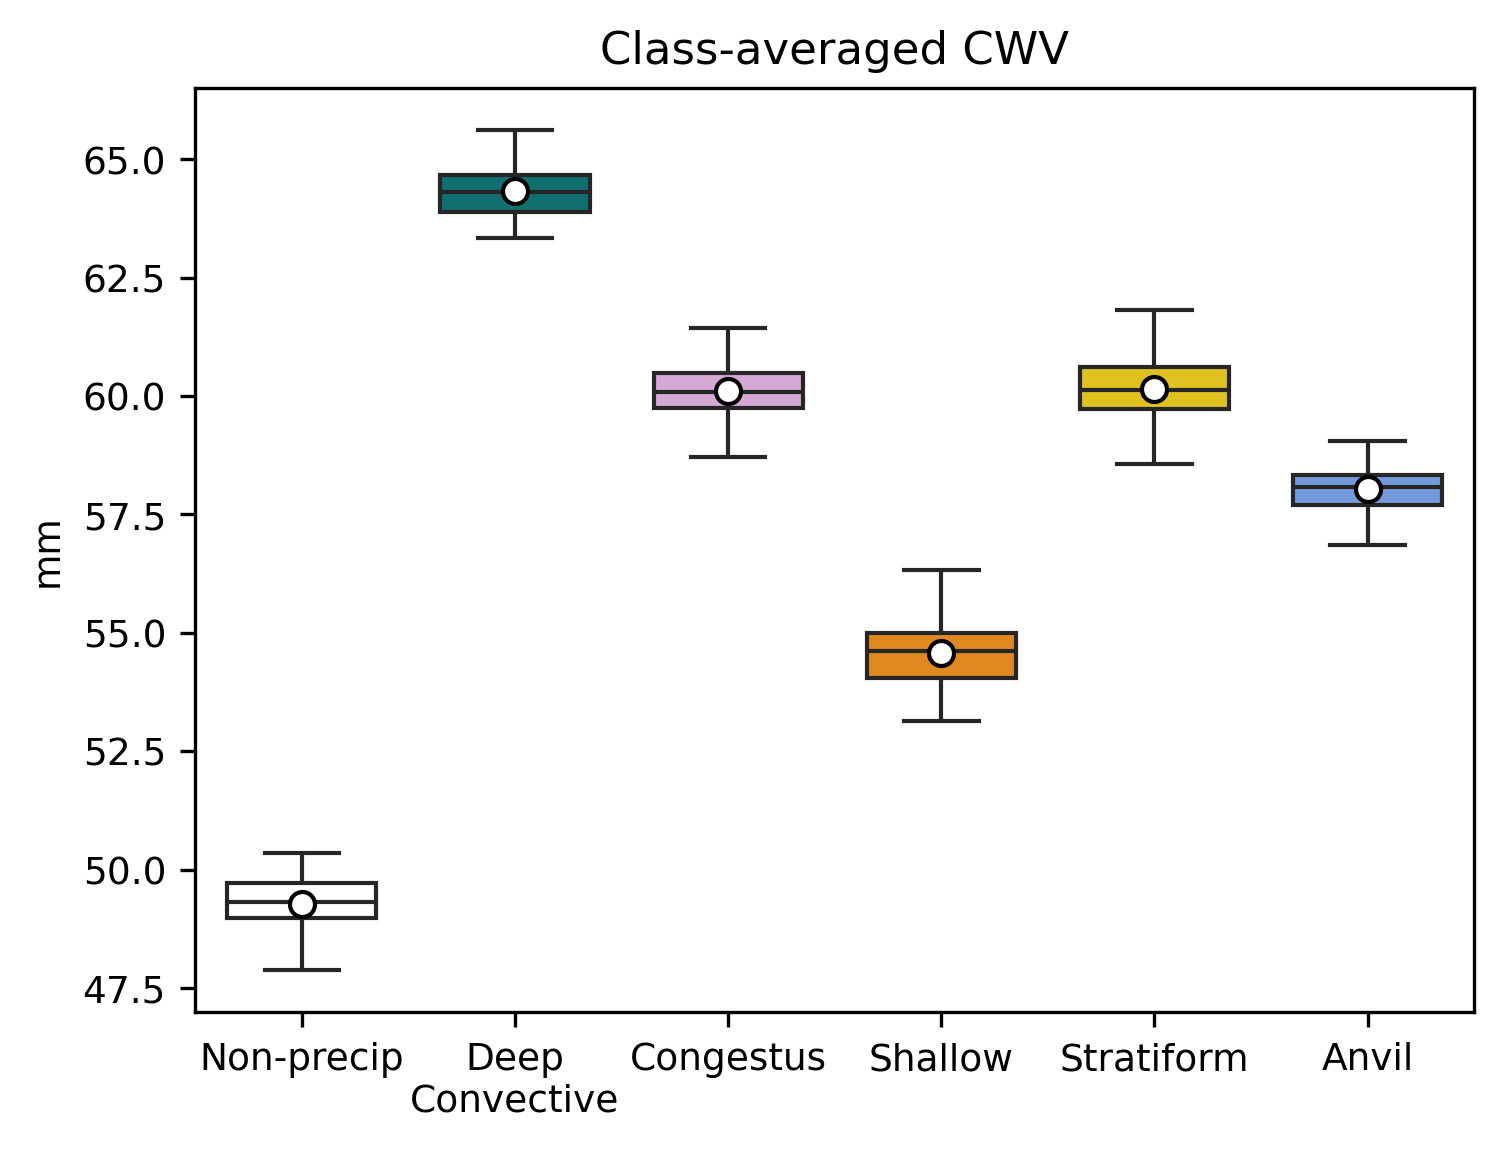

In [21]:
print("RUNNING CWV")

units = "mm"
title_tag = "CWV"
fig_tag = "cwv"
create_boxplot(np.reshape(cwv_masked[:,ktest0],(6,nmem*nt)), tests[ktest0], title_tag, fig_tag,  units)

RUNNING LWACRE


/tmp/ipykernel_27231/1785360276.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


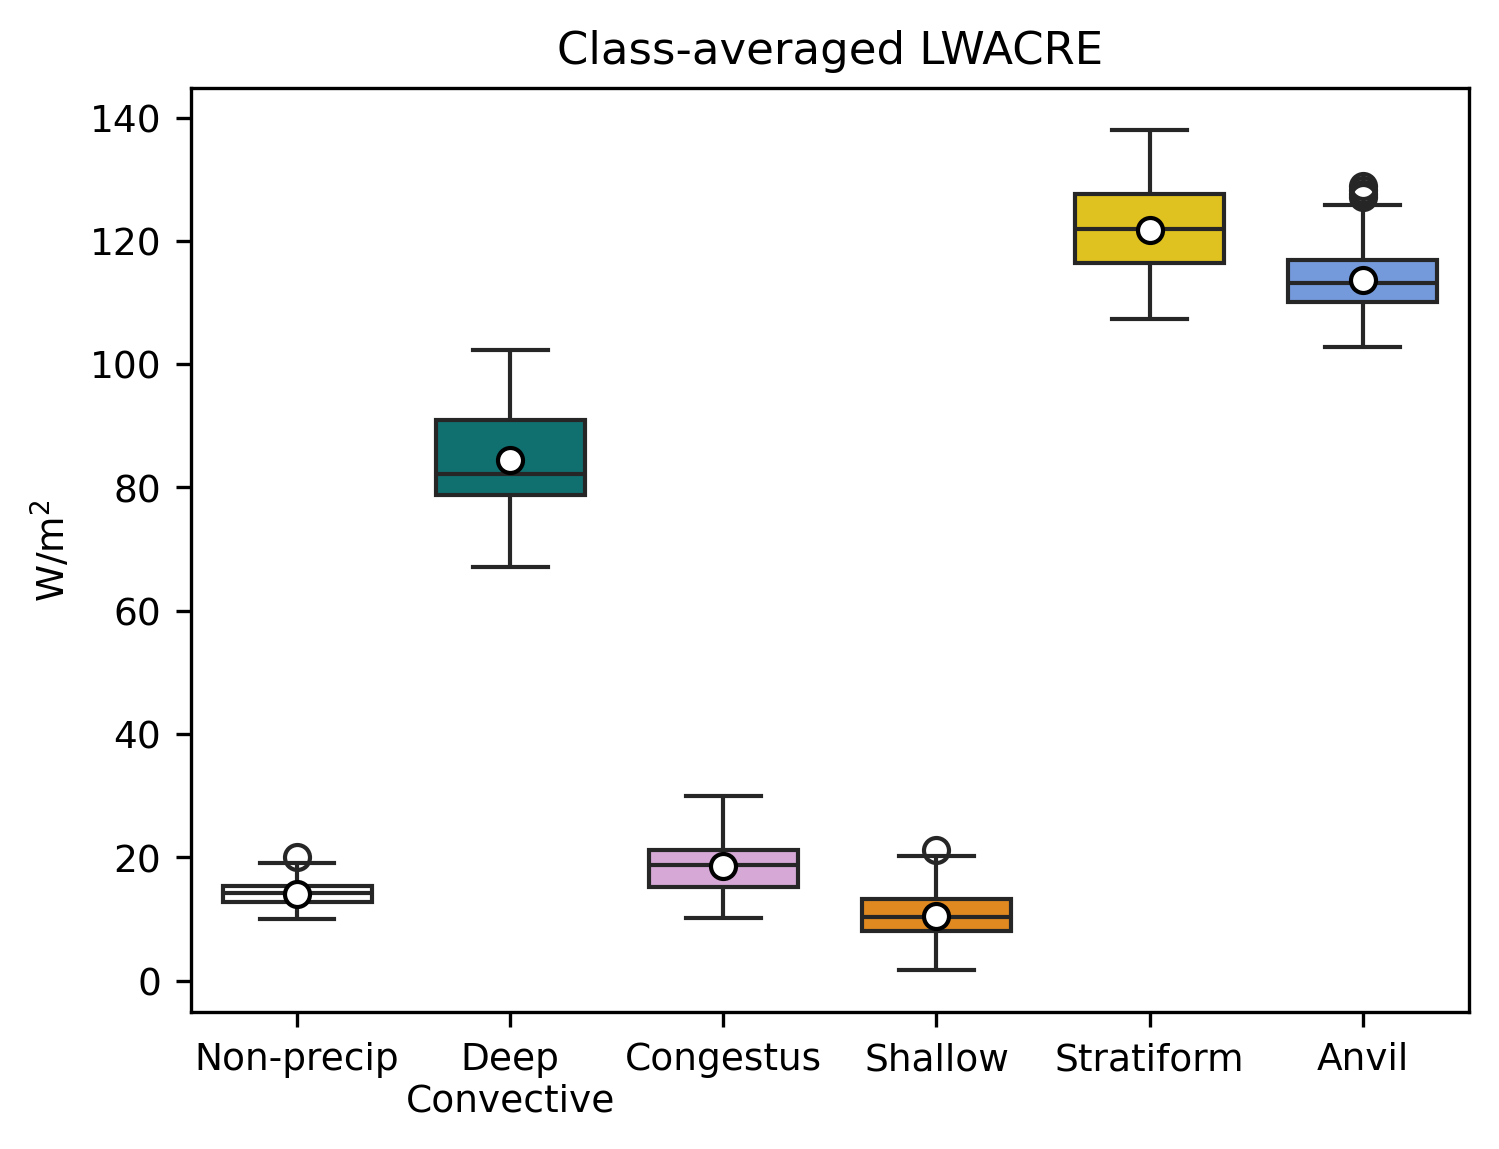

In [22]:
print("RUNNING LWACRE")

units = "W/m$^2$"
title_tag = "LWACRE"
fig_tag = "lwacre"
create_boxplot(np.reshape(lwacre_masked[:,ktest0],(6,nmem*nt)), tests[ktest0], title_tag, fig_tag, units)

print("DONE")

In [23]:
# print("RUNNING VMFup")

# units = "kg/m/s"
# title_tag = "VMFup"
# fig_tag = "vmfu"
# create_boxplot(vmfu_indexed_1hr, title_tag, fig_tag, units, yscale='log')

# print("DONE")
# print("RUNNING CONDH")

# title_tag = "CONDH"
# units = "mm/day"
# fig_tag = "condh"
# create_boxplot(condh_indexed_1hr, title_tag, fig_tag, units, yscale='log')

In [24]:
# print("RUNNING QRAIN")

# units = "mm"
# title_tag = "QRAIN"
# fig_tag = "qrain"
# create_boxplot_noclear(np.reshape(qrain_masked[:,ktest0],(6,nmem*nt)), tests[ktest0], title_tag, fig_tag, units, yscale="log")

# print("DONE")

RUNNING RAIN


/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


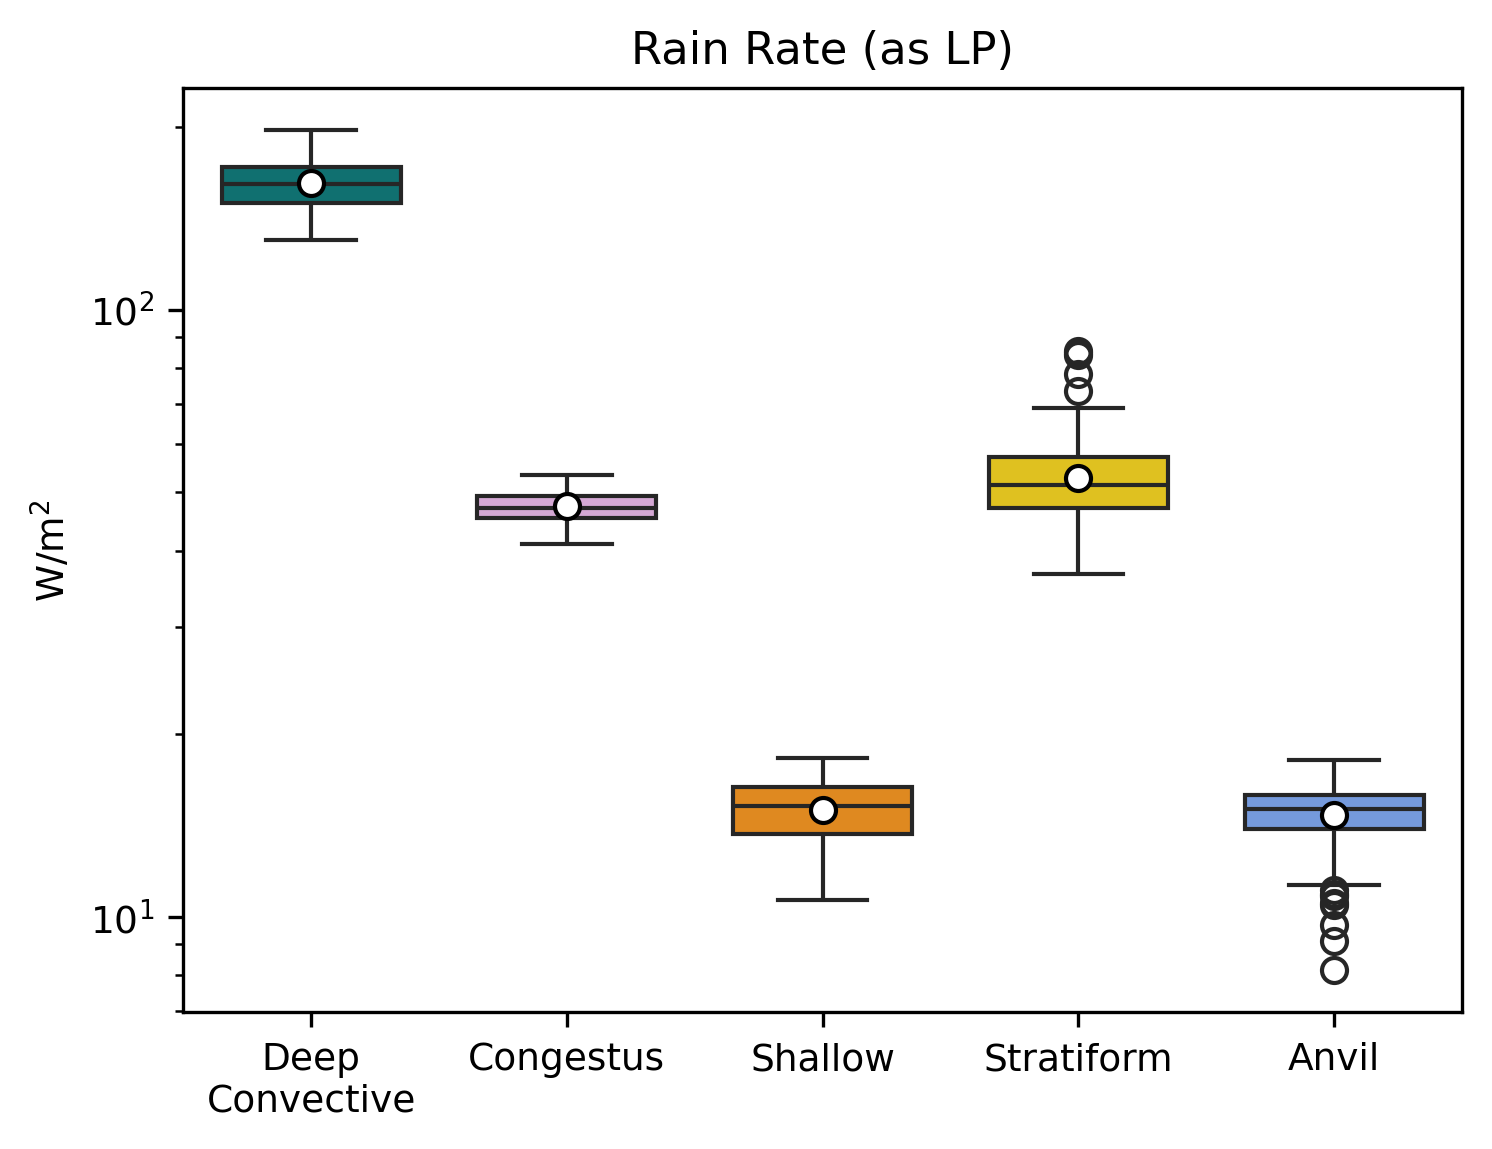

In [25]:
print("RUNNING RAIN")

lv0=2.5e6
rain_wm2 = rain_masked[:,0]*lv0/(24*3600)

# units = "mm/d"
units = "W/m$^2$"
title_tag = "Rain Rate (as LP)"
fig_tag = "rain"
create_boxplot_noclear(np.reshape(rain_masked[:,ktest0],(6,nmem*nt)), tests[ktest0], title_tag, fig_tag, units, yscale="log")

print("DONE")

In [26]:
# print("RUNNING LWFB1")

# # Local LW Feedback
# units = "W/m$^2$ / mm"
# title_tag = "LWACRE/QRAIN"
# fig_tag = "lwfdb_qrain"
# create_boxplot_noclear(lwfeedb1_indexed_1hr, title_tag, fig_tag, units, yscale="log")

# print("DONE")

In [27]:
# print("RUNNING LWFB1")

# # Local LW Feedback
# units = "W/m$^2$ / mm"
# title_tag = "LWACRE/QRAIN"
# fig_tag = "lwfdb_qrain"
# create_boxplot_noclear(np.reshape(lwfeedback1[:,ktest0],(6,nmem*nt)), tests[ktest0], title_tag, fig_tag, units, yscale="log")

# print("DONE")

RUNNING LWFB1


/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


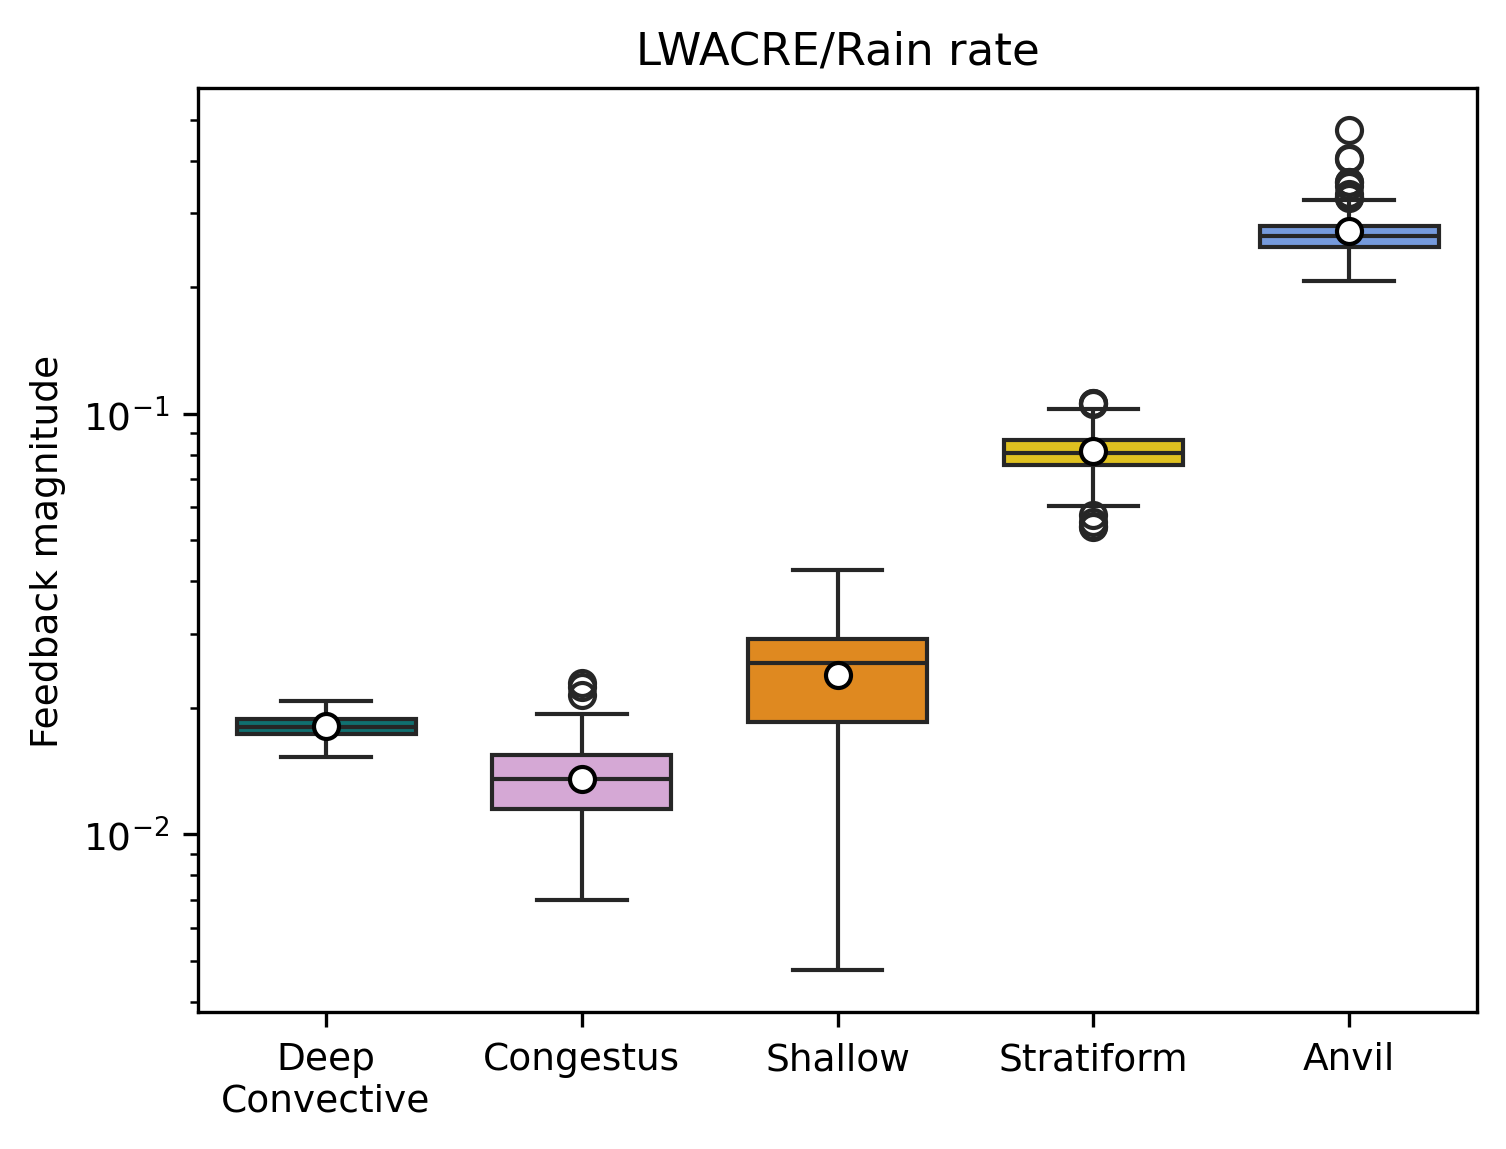

In [28]:
print("RUNNING LWFB1")

# Use W/m2 for rainfall
lv0=2.5e6
rain_wm2 = rain_masked*lv0/(24*3600)
lwfeedback2 = lwacre_masked / rain_wm2
lwfeedback2 = lwfeedback2[:,ktest0]

# Local LW Feedback
# units = "W/m$^2$ / mm/d"
units = "Feedback magnitude"
title_tag = "LWACRE/Rain rate"
fig_tag = "lwfdb_rain"
create_boxplot_noclear(np.reshape(lwfeedback2,(6,nmem*nt)), tests[ktest0], title_tag, fig_tag, units, yscale="log")

print("DONE")

RUNNING LWFB1*AREA


/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


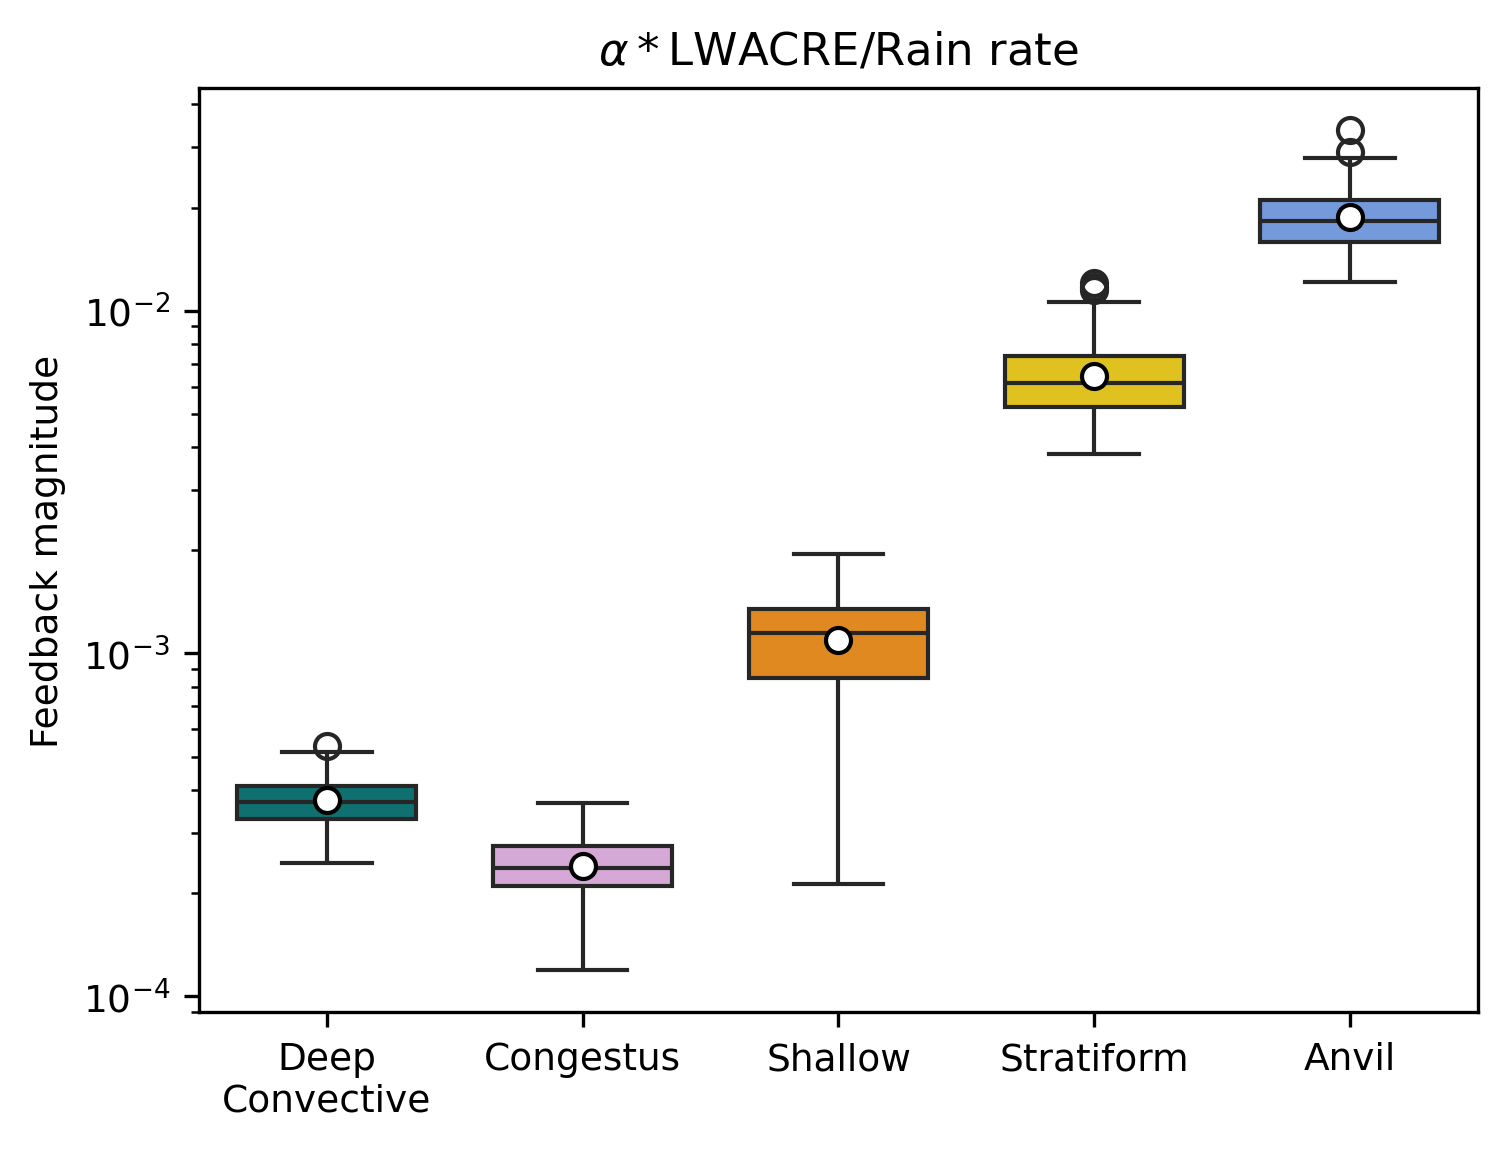

In [29]:
print("RUNNING LWFB1*AREA")

# Use W/m2 for rainfall
lv0=2.5e6
rain_wm2 = rain_masked*lv0/(24*3600)
lwfeedback2 = lwacre_masked*area_frac / rain_wm2
lwfeedback2 = lwfeedback2[:,ktest0]

# Local LW Feedback
# units = "W/m$^2$ / mm/d"
units = "Feedback magnitude"
title_tag = r"$\alpha*$"+"LWACRE/Rain rate"
fig_tag = "lwfdb_rain_alpha"
create_boxplot_noclear(np.reshape(lwfeedback2,(6,nmem*nt)), tests[ktest0], title_tag, fig_tag, units, yscale="log")

print("DONE")

RUNNING AREA
DONE


/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


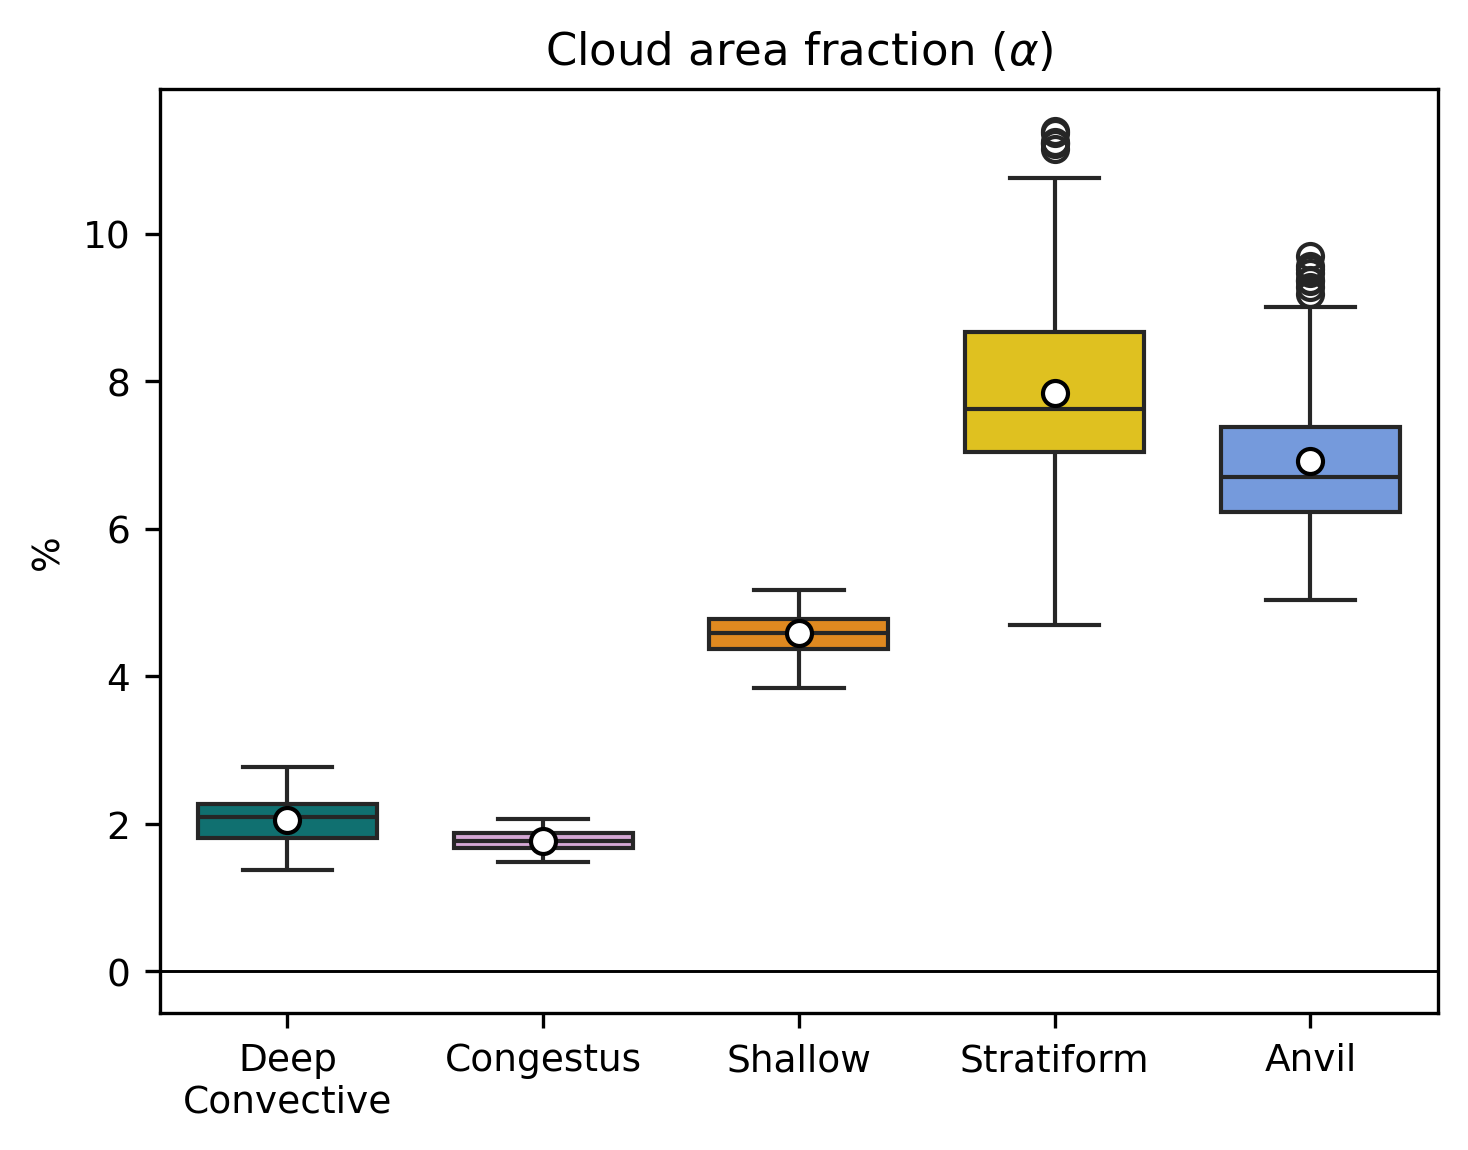

In [30]:
print("RUNNING AREA")

units = "%"
title_tag = r"Cloud area fraction ($\alpha$)"
fig_tag = "pclass_area"
create_boxplot_noclear(np.reshape(area_frac[:,ktest0]*1e2,(6,nmem*nt)), tests[ktest0], title_tag, fig_tag, units, yscale="linear")

print("DONE")

RUNNING VMF
DONE


/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


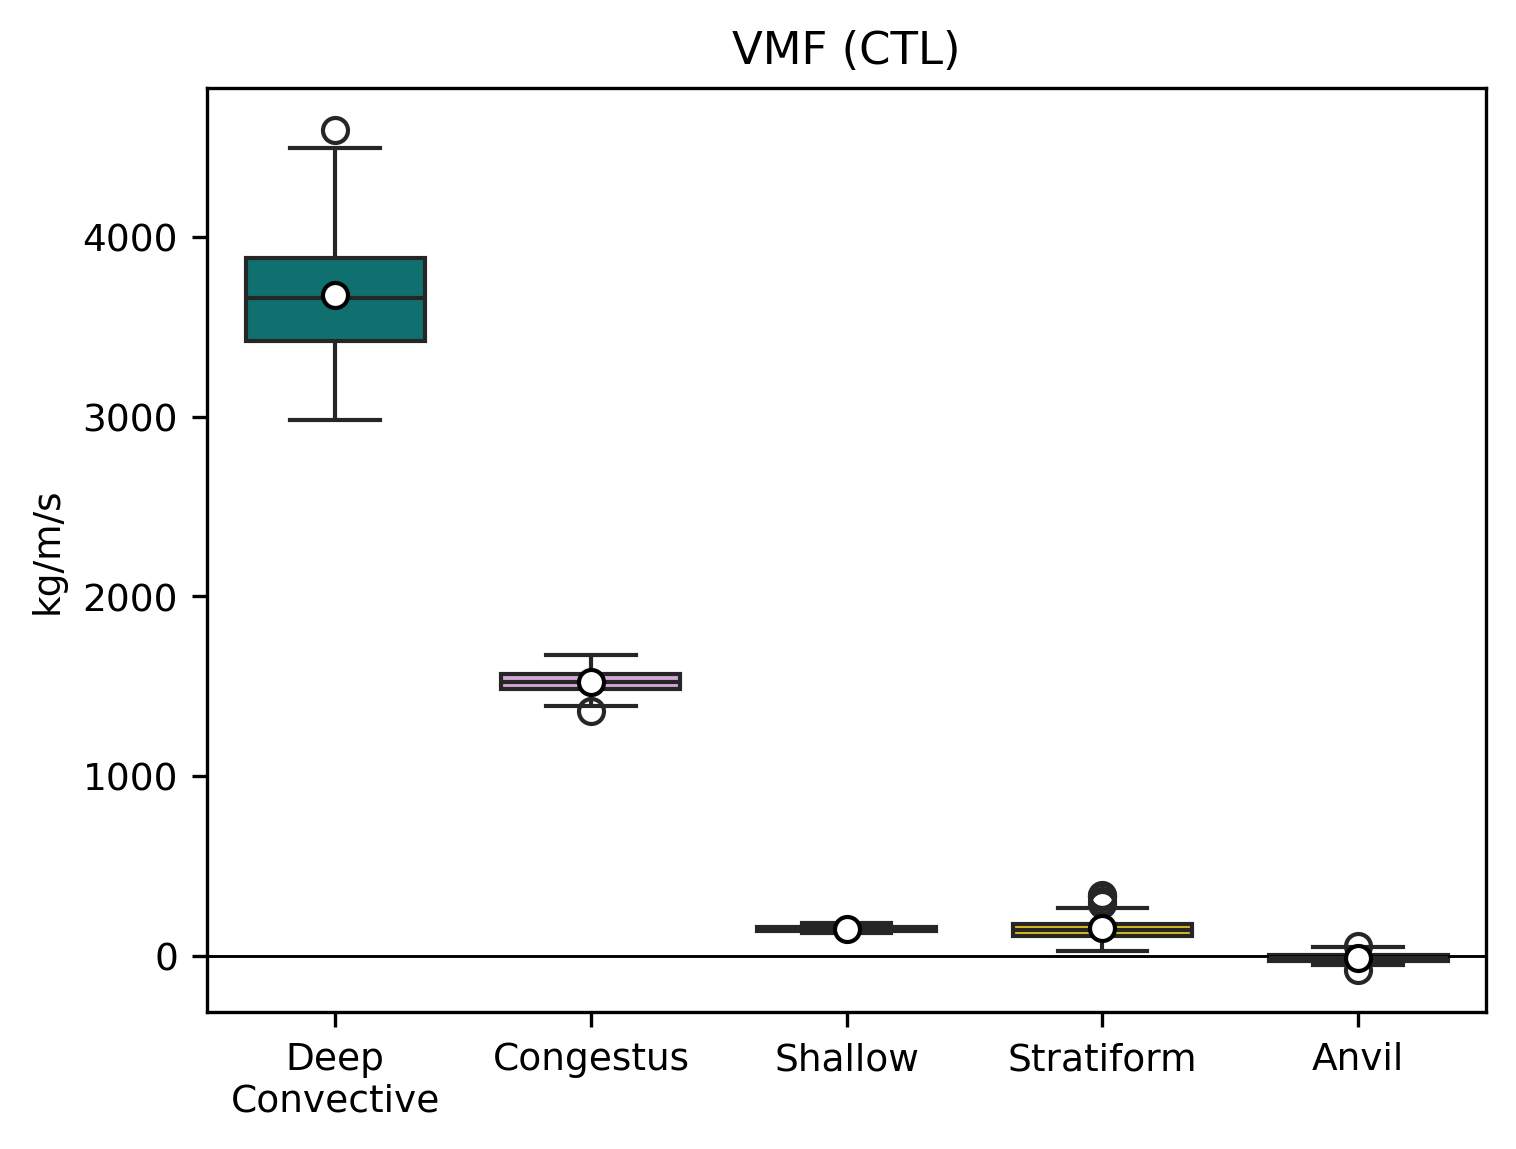

In [31]:
print("RUNNING VMF")

rawvar = vmf_masked
invar = np.reshape(rawvar[:,ktest0],(6,nmem*nt))

units = "kg/m/s"
title_tag = "VMF (CTL)"
fig_tag = "vmf"
create_boxplot_noclear(invar, tests[ktest0], title_tag, fig_tag, units, yscale="linear")

print("DONE")

RUNNING LP


/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


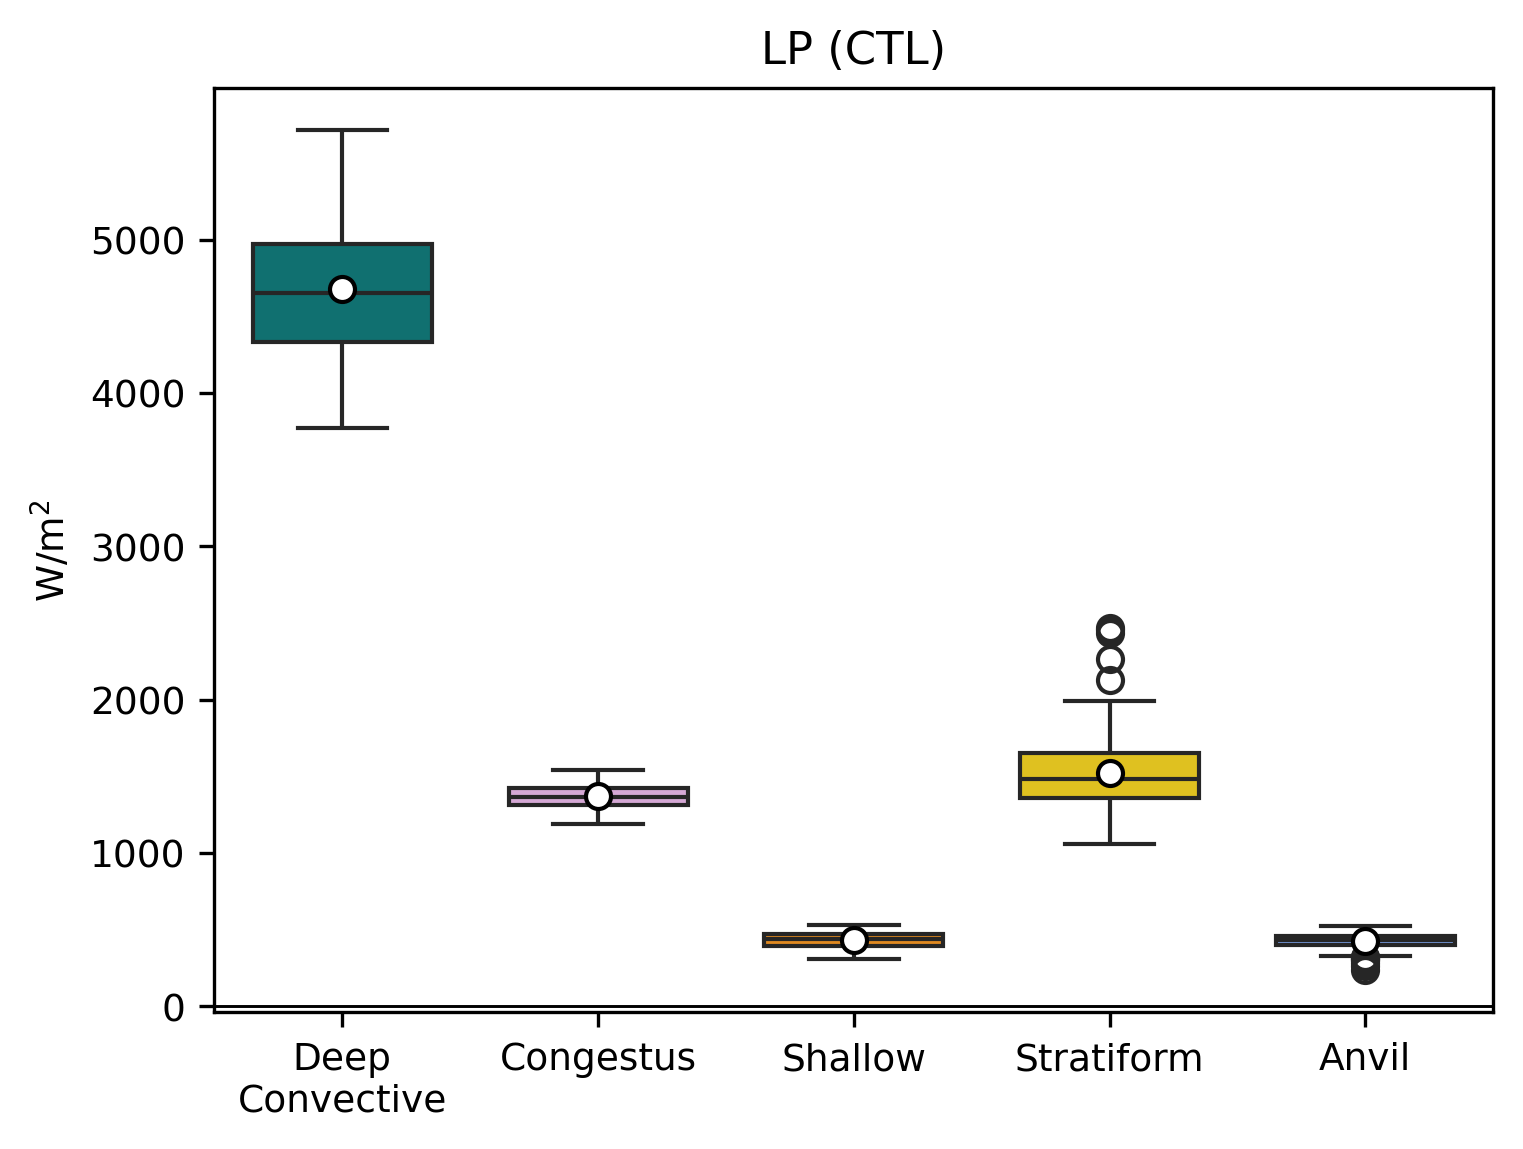

In [32]:
print("RUNNING LP")

rawvar = rain_wm2
invar = np.reshape(rawvar[:,ktest0],(6,nmem*nt))

units = "W/m$^2$"
title_tag = "LP (CTL)"
fig_tag = "lvp"
create_boxplot_noclear(invar, tests[ktest0], title_tag, fig_tag, units, yscale="linear")

print("DONE")

RUNNING VMF


/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)
/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)
/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)
/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


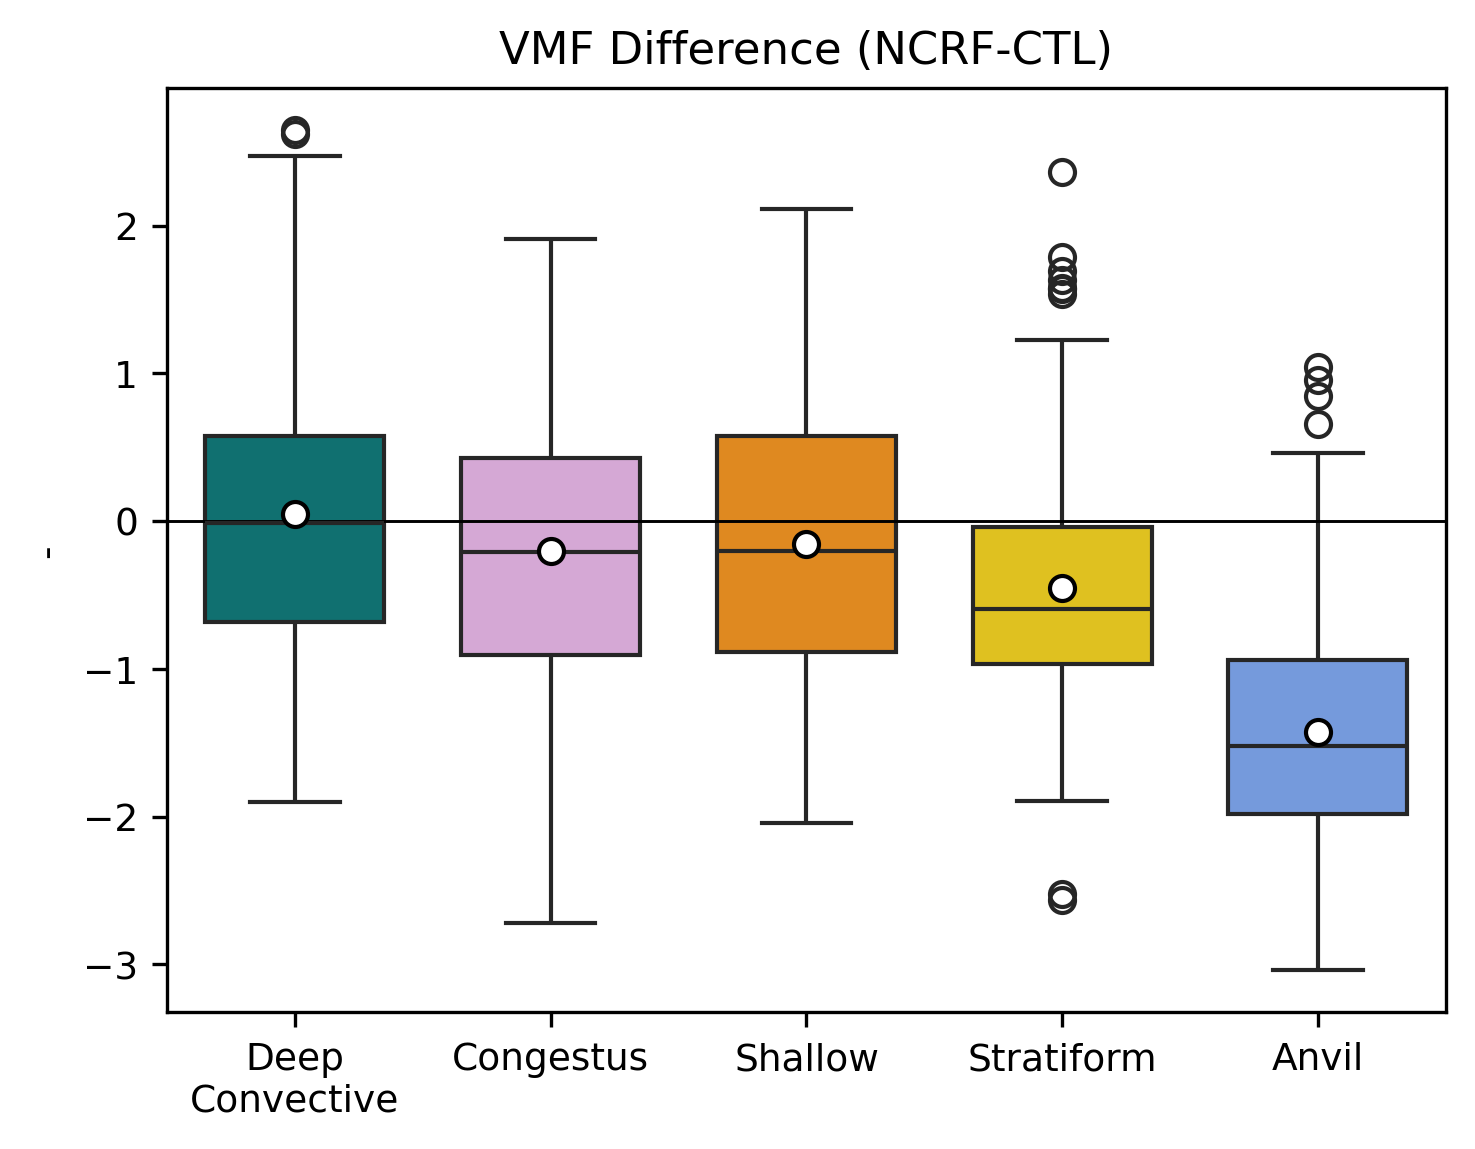

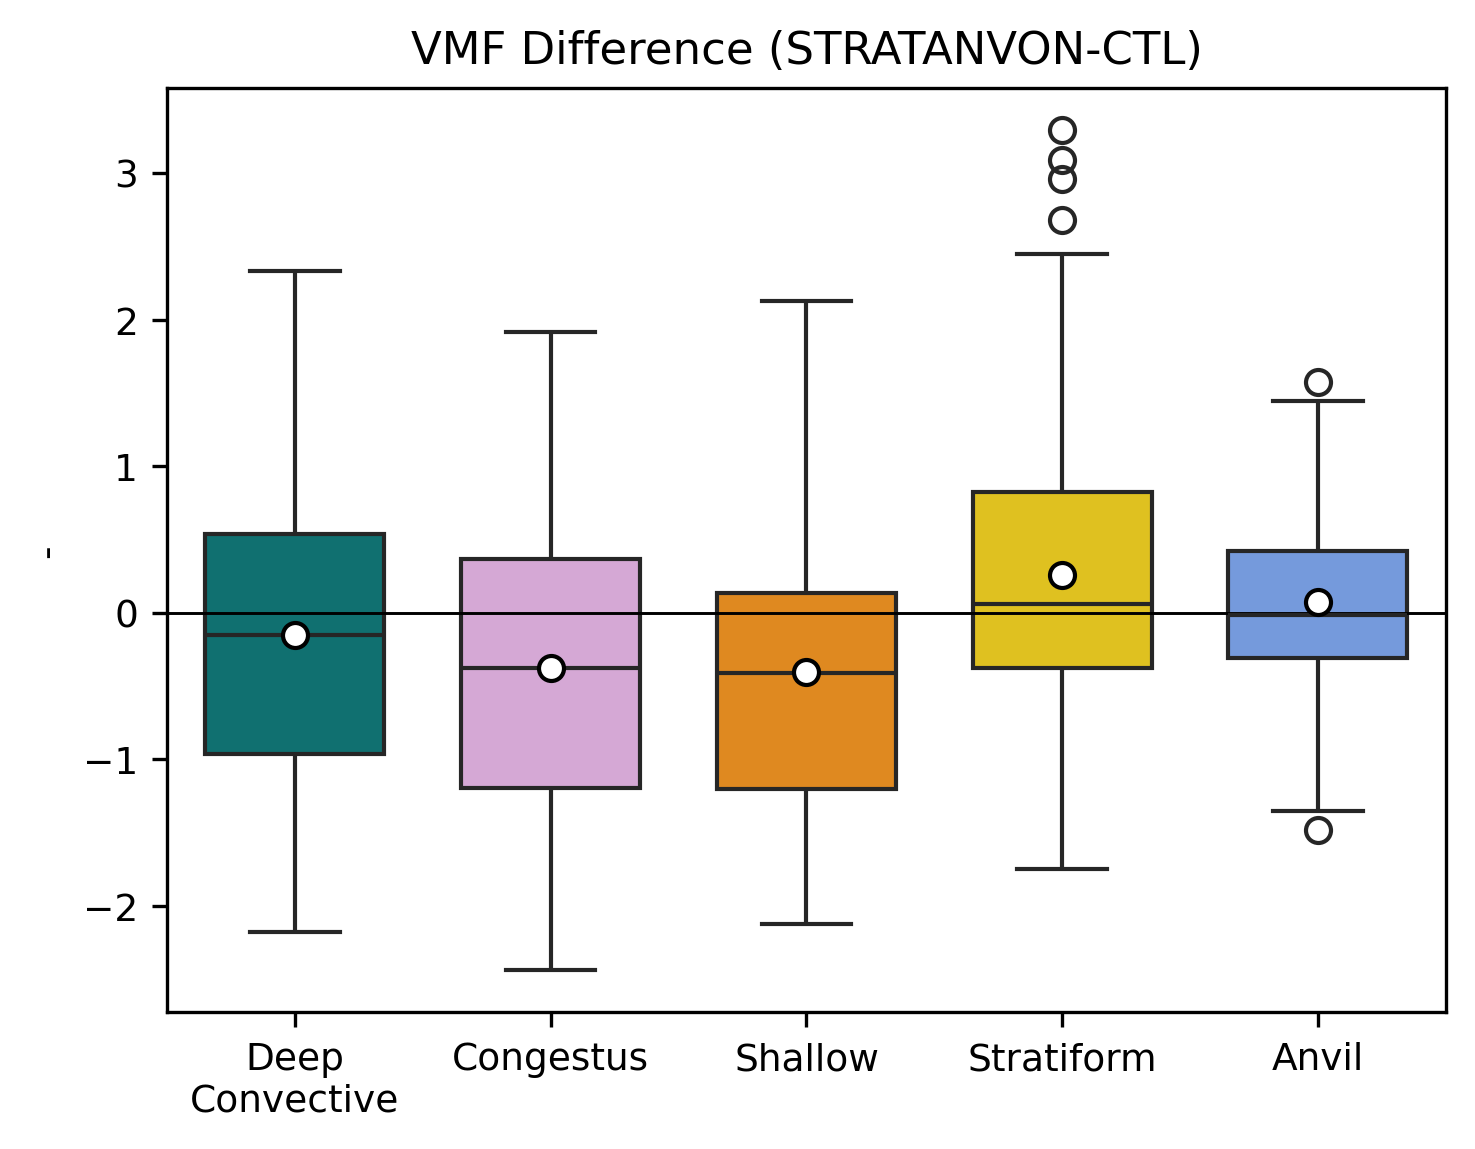

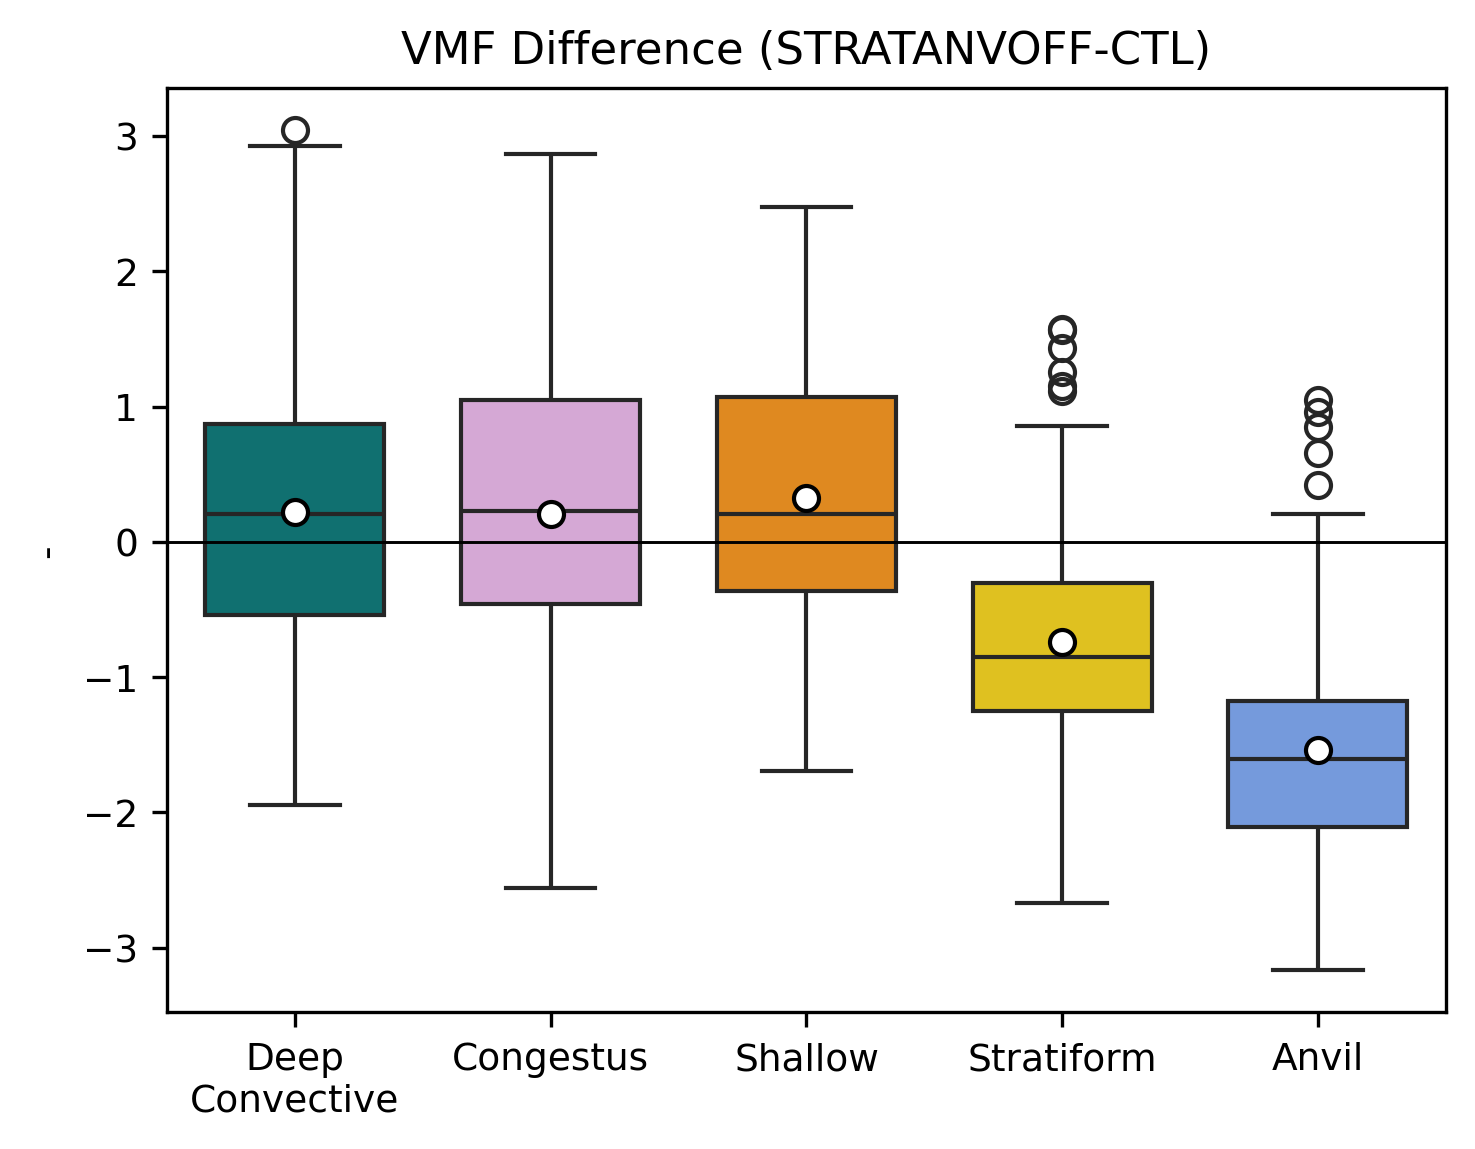

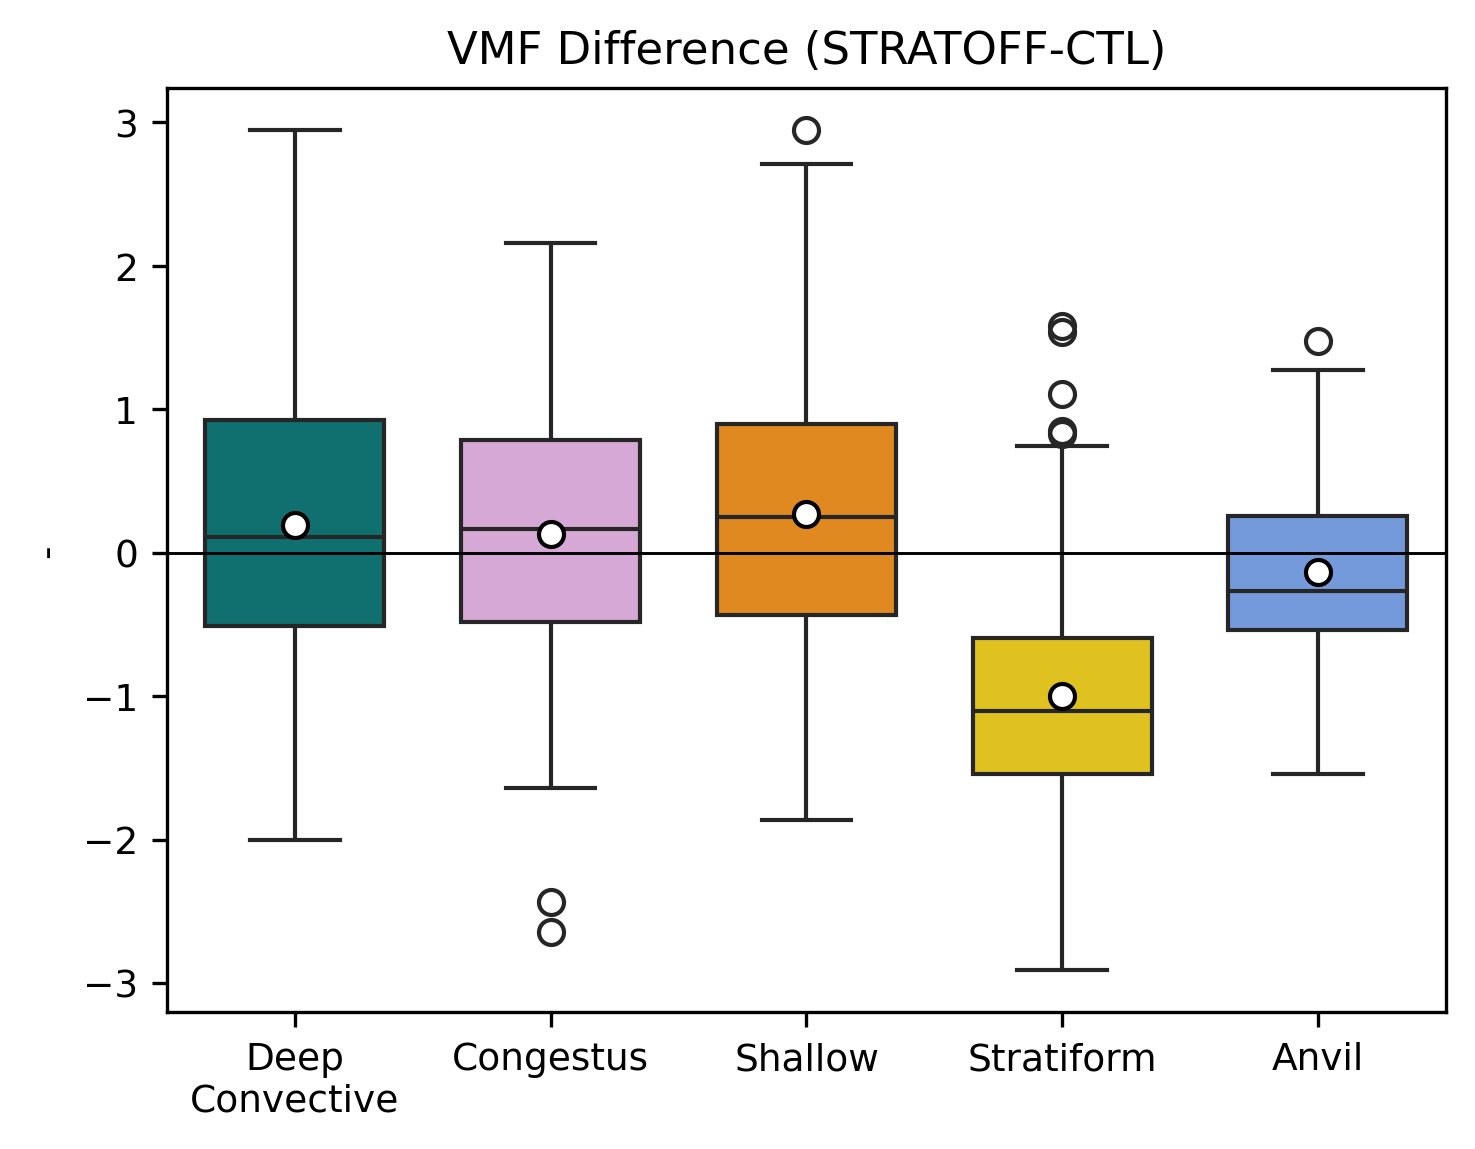

In [33]:
print("RUNNING VMF")

rawvar = vmf_masked

ctl_ref = rawvar[:,0]
ctl_mn = np.mean(ctl_ref,axis=(1,2))
# ctl_sddev = np.std(ctl_ref,axis=(1,2))
sddev = np.std(rawvar,axis=(1,2,3))

for itest in range(1,ntest):
    # invar = np.reshape(rawvar[:,itest] - rawvar[:,0],(6,nmem*nt))
    # invar = (rawvar[:,itest] - ctl_mn[:,np.newaxis,np.newaxis]) / ctl_sddev[:,np.newaxis,np.newaxis]
    invar = (rawvar[:,itest] - ctl_mn[:,np.newaxis,np.newaxis]) / sddev[:,np.newaxis,np.newaxis]
    invar_reshaped = np.reshape(invar,(6,nmem*nt))
    # rawvar = np.mean(rawvar,axis=3)
    # invar = np.reshape(rawvar[:,1] - rawvar[:,0],(6,nmem))

    # units = "kg/m/s"
    units = "-"
    title_tag = "VMF Difference ("+tests_str[itest]+'-'+tests_str[0]+')'
    fig_tag = "vmf_diff"
    create_boxplot_noclear(invar_reshaped, tests[itest], title_tag, fig_tag, units, yscale="linear")

print("DONE")

RUNNING VMF


/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


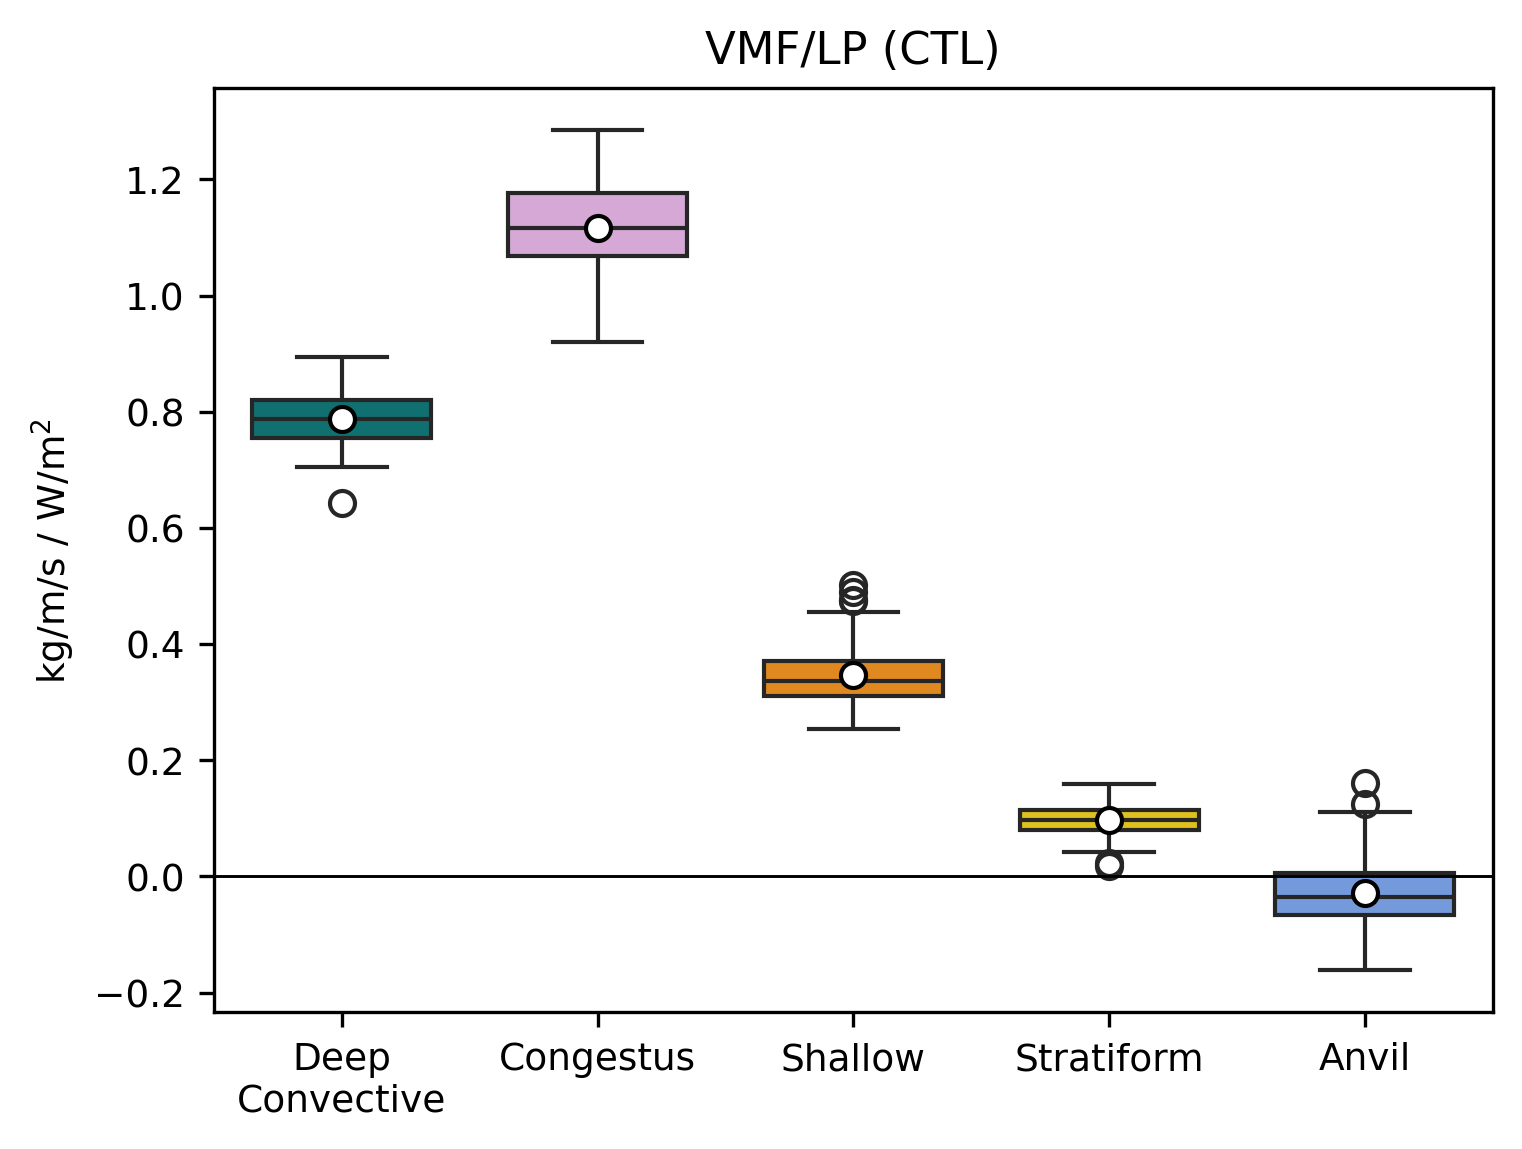

In [34]:
print("RUNNING VMF")

rain_wm2 = rain_masked*lv0/(24*3600)

rawvar = vmf_masked/rain_wm2
invar = np.reshape(rawvar[:,0],(6,nmem*nt))
# rawvar = np.mean(rawvar,axis=3)
# invar = np.reshape(rawvar[:,1] - rawvar[:,0],(6,nmem))

units = "kg/m/s / W/m$^2$"
title_tag = "VMF/LP (CTL)"
fig_tag = "vmf_norm"
create_boxplot_noclear(invar, tests[ktest0], title_tag, fig_tag, units, yscale="linear")

print("DONE")

RUNNING VMF


/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)
/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)
/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)
/tmp/ipykernel_27231/1718318549.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


DONE


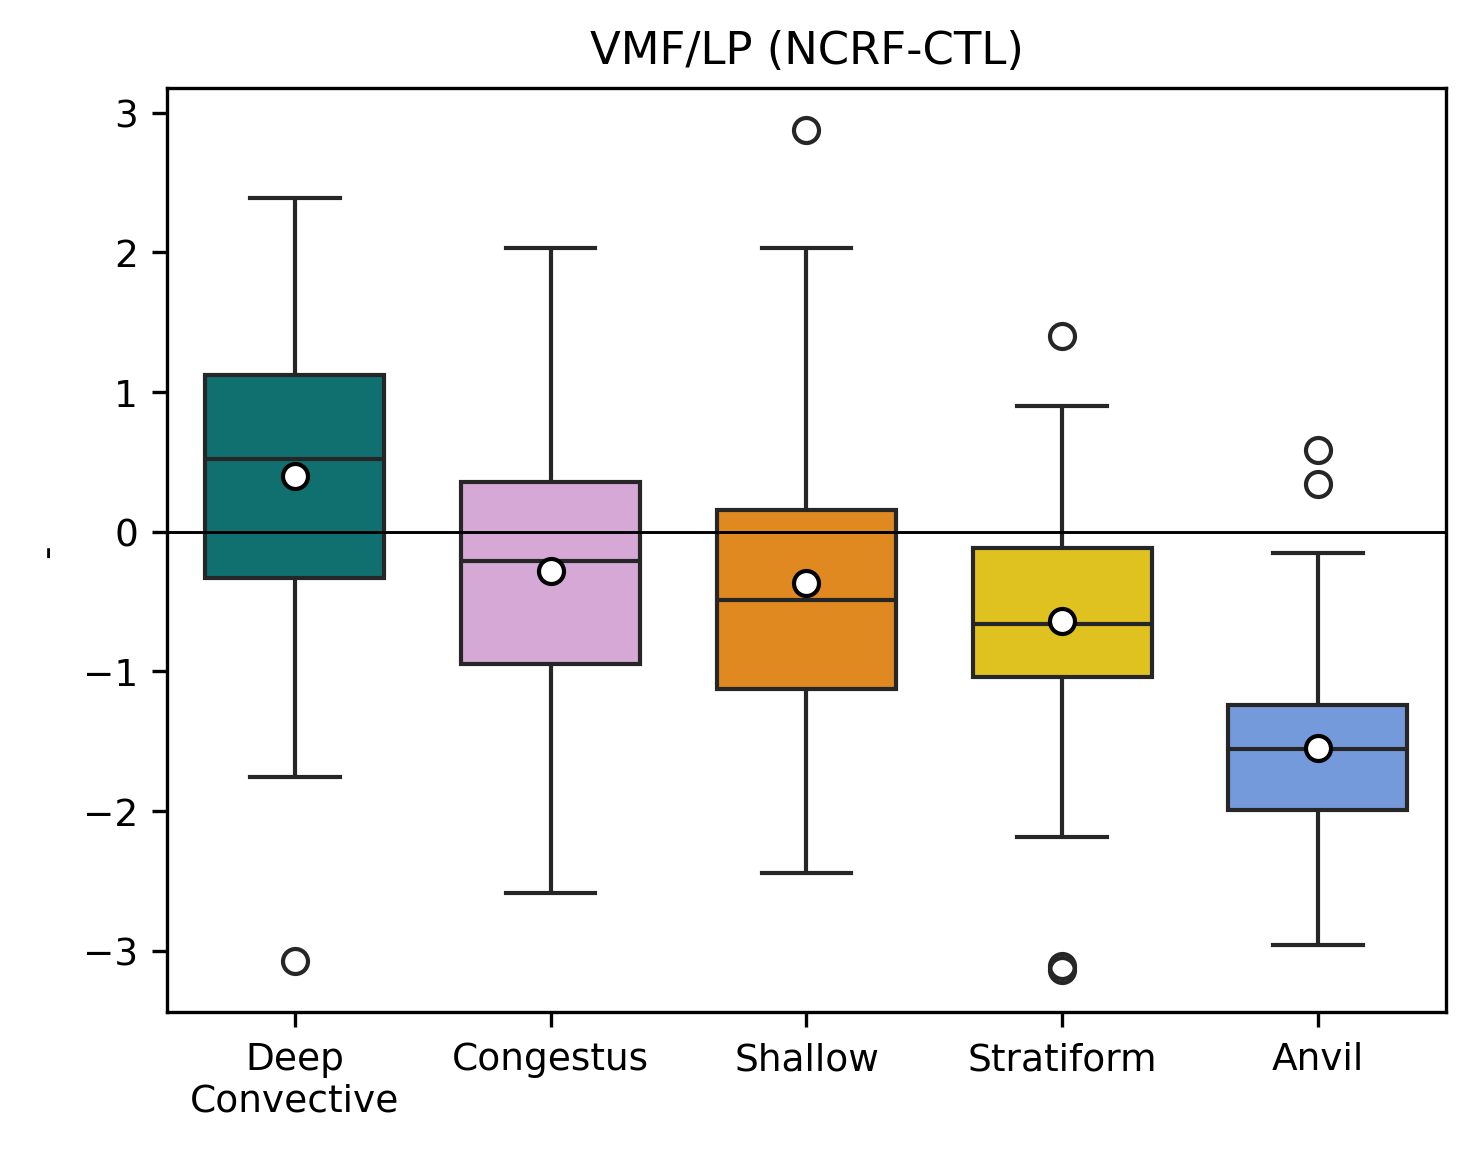

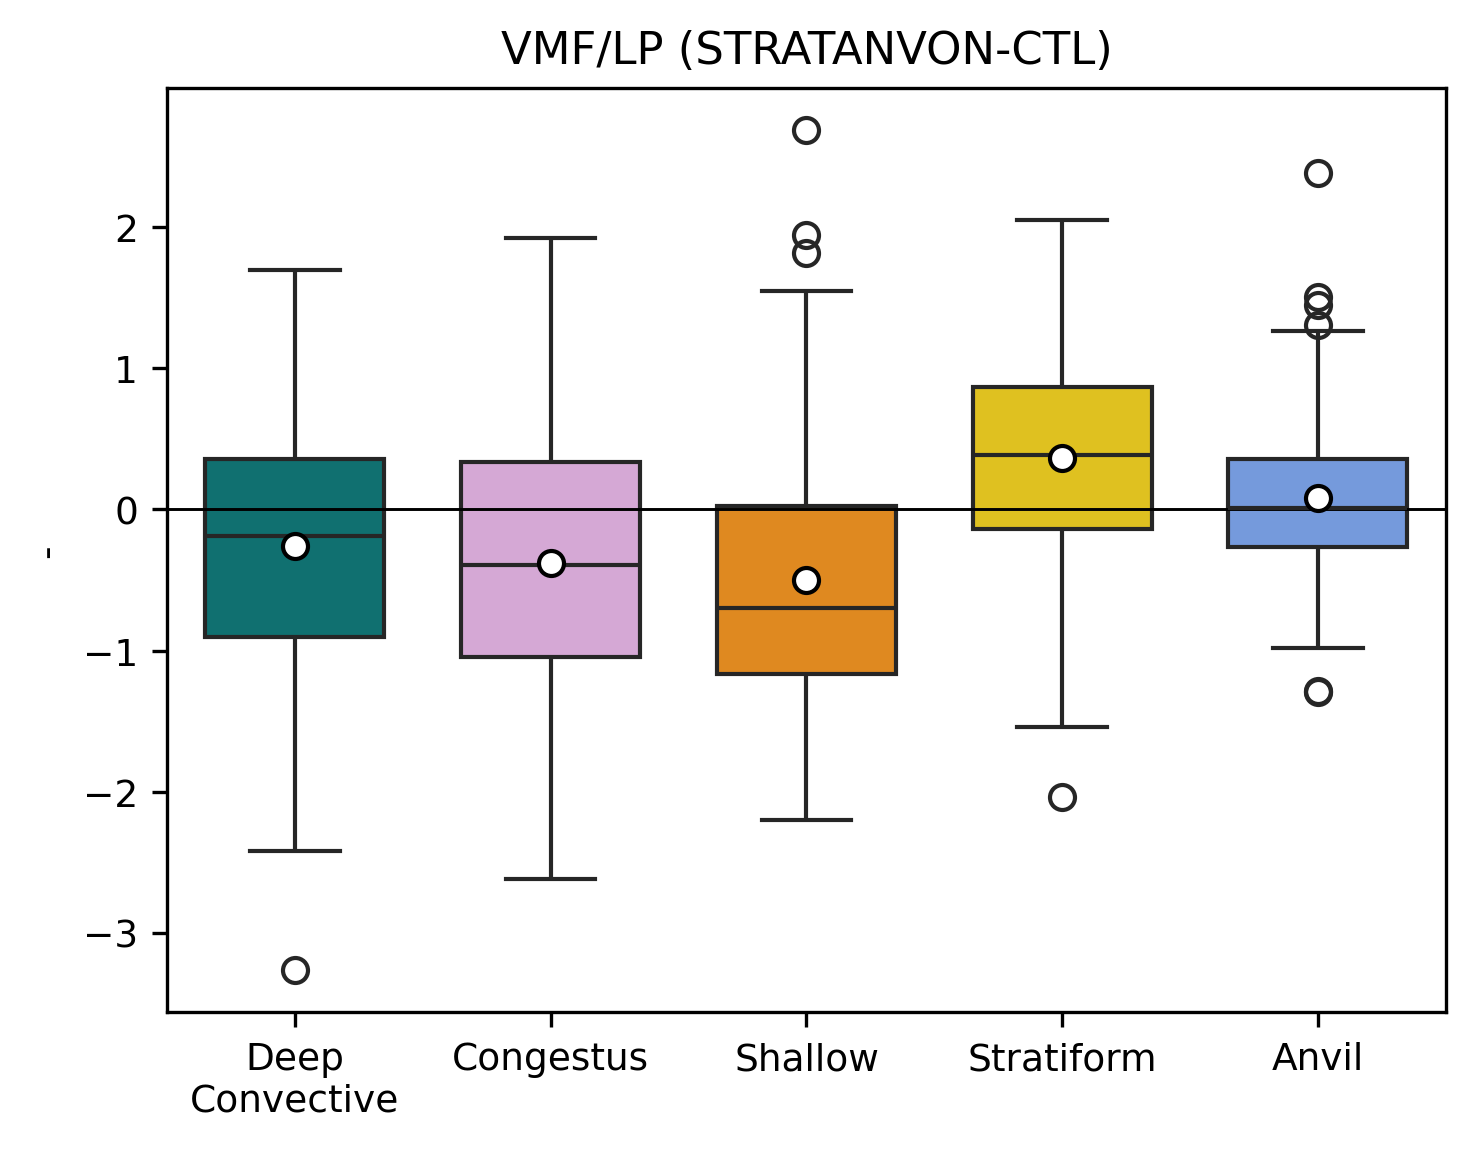

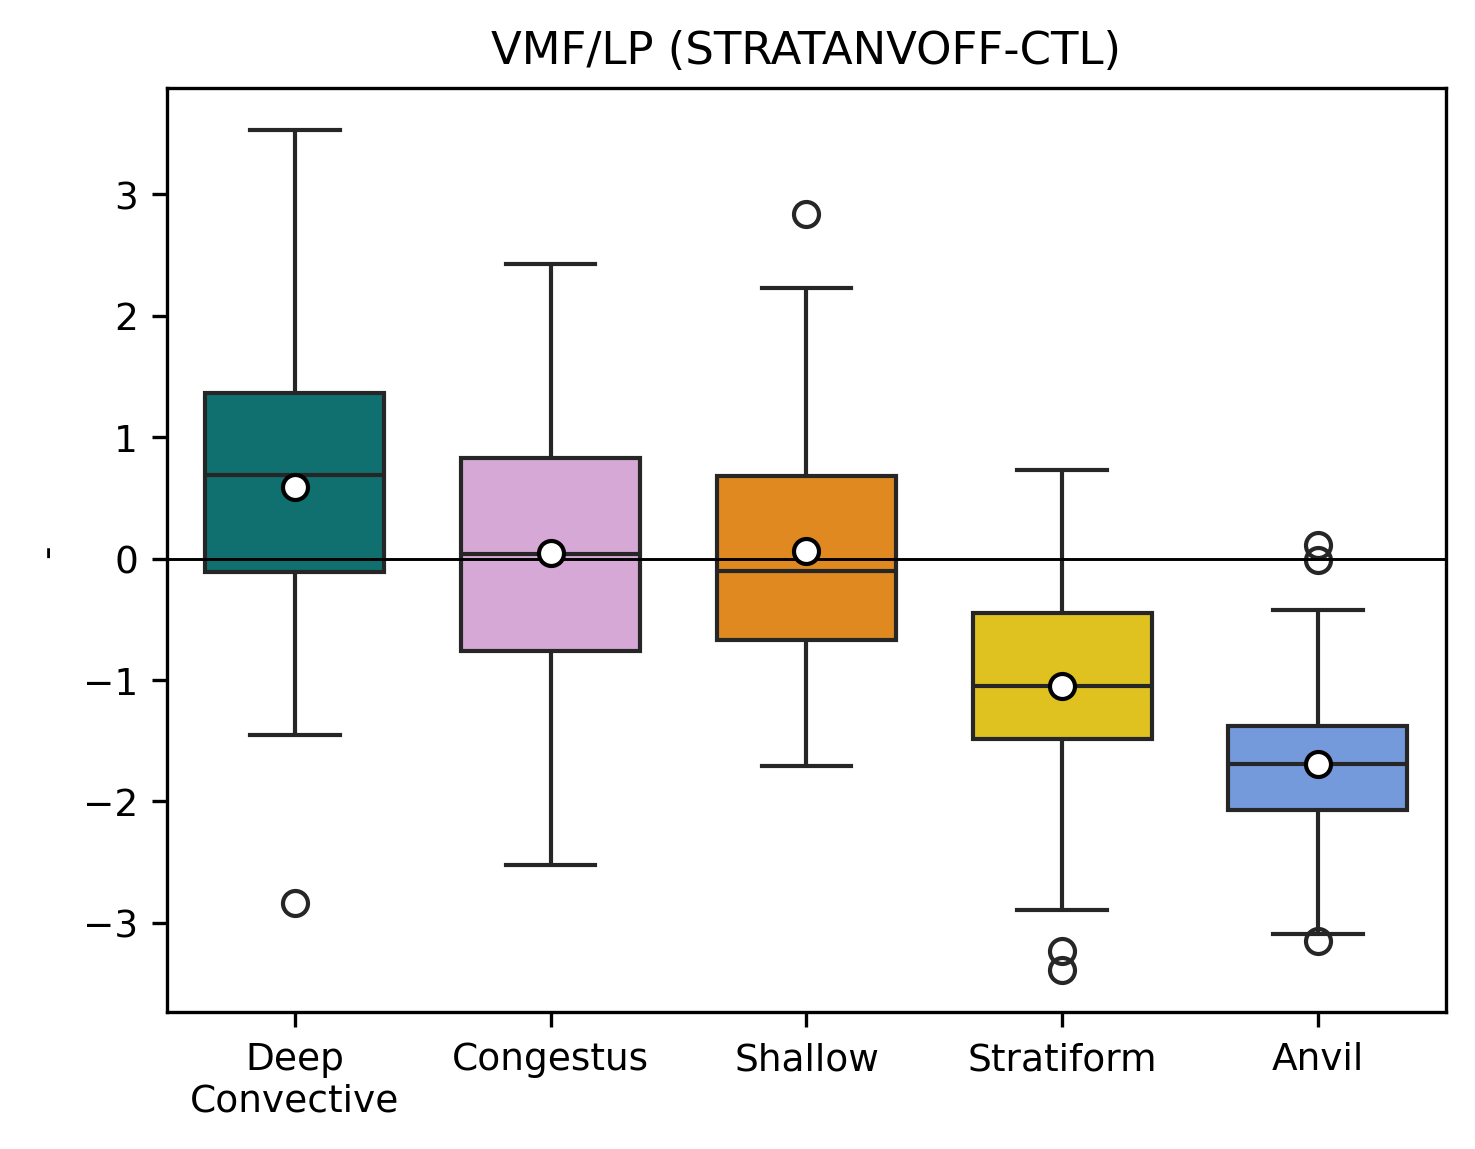

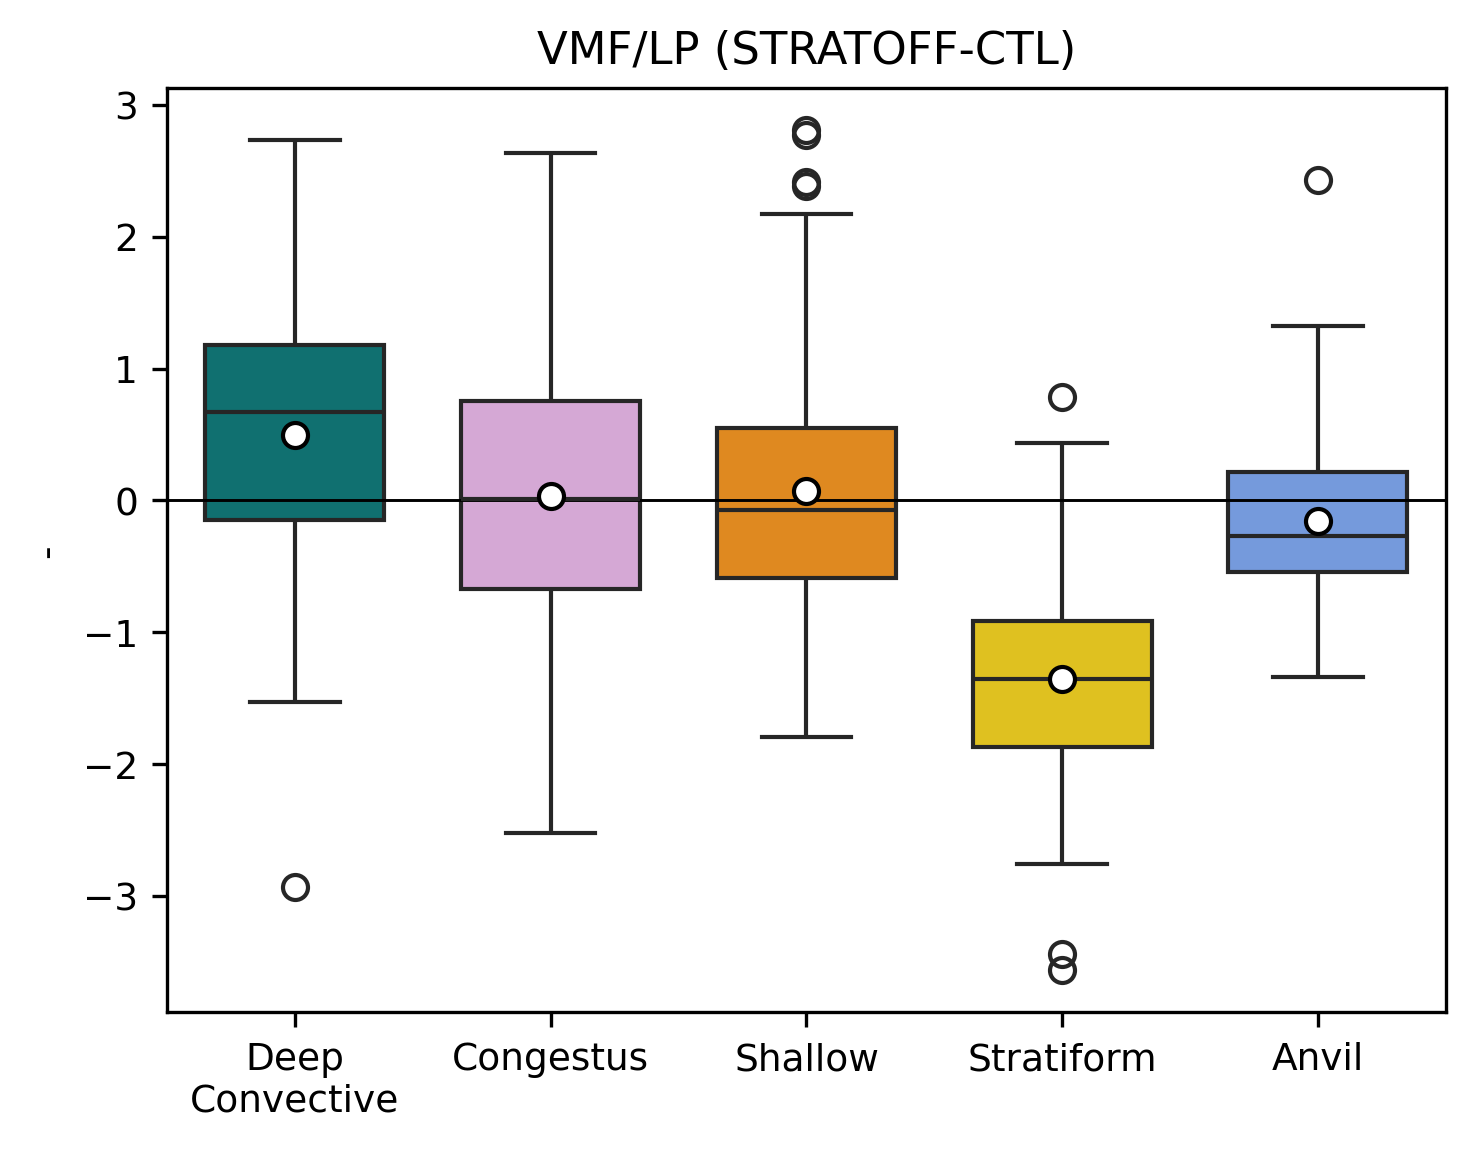

In [35]:
print("RUNNING VMF")

rain_wm2 = rain_masked*lv0/(24*3600)
rawvar = vmf_masked/rain_wm2

tests_str2 = ['CTL','NCRF','STRAT\nANVIL\nON','STRAT\nANVIL\nOFF','STRAT\nOFF']

c_name = ['Non-precip', 'Deep Convective', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
c_name2 = ['nonp', 'deepc', 'cong', 'shall', 'strat', 'anvil']

ctl_ref = rawvar[:,0]
ctl_mn = np.mean(ctl_ref,axis=(1,2))
# ctl_sddev = np.std(ctl_ref,axis=(1,2))
sddev = np.std(rawvar,axis=(1,2,3))

for itest in range(1,ntest):

    # invar = (rawvar[:,itest] - ctl_mn[:,np.newaxis,np.newaxis]) / ctl_sddev[:,np.newaxis,np.newaxis]
    invar = (rawvar[:,itest] - ctl_mn[:,np.newaxis,np.newaxis]) / sddev[:,np.newaxis,np.newaxis]
    invar_reshaped = np.reshape(invar,(6,nmem*nt))

    # invar = np.reshape(rawvar[ipclass],(ntest,nmem*nt))
    # invar = np.reshape((ctlmn[:,np.newaxis,np.newaxis] - rawvar[:,itest]),(6,nmem*nt))
    # invar = np.reshape((var_ctl - rawvar[:,itest]),(6,nmem*nt))
    # invar = np.reshape(rawvar[:,itest],(6,nmem*nt))
    # rawvar = np.mean(rawvar,axis=3)
    # invar = np.reshape(rawvar[:,1] - rawvar[:,0],(6,nmem))

    # units = "kg/m/s / W/m2"
    units = "-"
    title_tag = "VMF/LP ("+tests_str[itest]+'-CTL)'
    # fig_tag = "vmf_norm_diff_"+c_name2[ipclass]
    fig_tag = "vmf_norm_diff_allpclass"
    create_boxplot_noclear(invar_reshaped, tests[itest], title_tag, fig_tag, units, yscale="linear")

print("DONE")

In [36]:
def create_boxplot_testcomp(invar, tests_str, title_tag, fig_tag, units, yscale='linear'):

    # c_name = ['Non-precip', 'Deep\nConvective', 'Congestus', 'Shallow\nConvective', 'Stratiform', 'Anvil']
    # cmap = ['white', 'teal', 'plum', 'darkorange', 'gold', 'cornflowerblue']
    c_name = tests_str
    cmap = ['teal', 'plum', 'darkorange', 'gold']#, 'cornflowerblue']
    sns.set_palette(cmap)

    fig = plt.figure(figsize=(4.5,4),dpi=300)
    # fig.set_facecolor('white')
    ax = fig.subplots(nrows=1, ncols=1)
    # sns.boxplot([invar[0], invar[1], invar[2], invar[3], invar[4], invar[5]],
    sns.boxplot([invar[0], invar[1], invar[2], invar[3]],#, invar[4]],
                width=0.7, showmeans=True, showfliers=False, #log_scale=log_scale,
                meanprops={"marker":"o", "markerfacecolor":"white", 
                "markeredgecolor":"black", "markersize":"6"})

    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.7)
    ax.set_yscale(yscale)
    # ax.set_ylim([1e-2,1e14])
    ax.set_xticklabels(c_name)
    plt.ylabel(units)#, weight='bold')
    # plt.title("Class-averaged "+title_tag)#, weight='bold')
    plt.title(title_tag)#, weight='bold')
    time_tag='_'+str(nt)+'hrs'
    # time_tag=''
    plt.savefig(figdir+fig_tag+'_'+test_str+time_tag+'.png',dpi=200, facecolor='white', bbox_inches='tight', pad_inches=0.2)

In [37]:
rawvar.shape

(6, 5, 10, 12)

RUNNING VMF
DONE


/tmp/ipykernel_27231/2708678906.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(c_name)


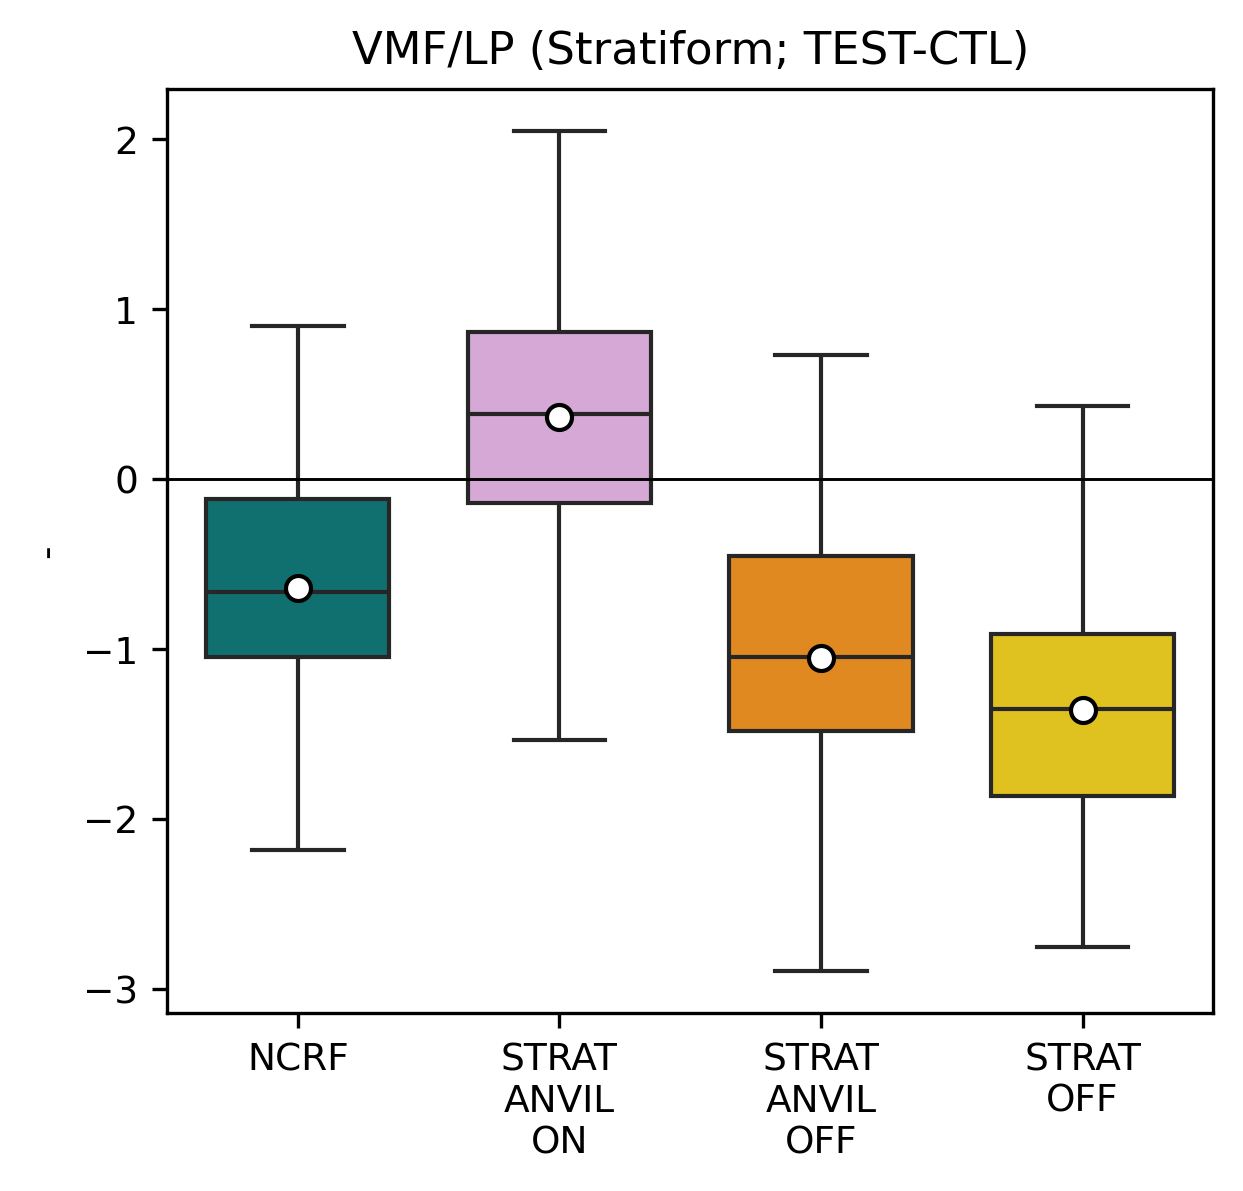

In [39]:
print("RUNNING VMF")

rain_wm2 = rain_masked*lv0/(24*3600)
rawvar = vmf_masked/rain_wm2

# tests_str2 = ['CTL','NCRF','STRAT\nANVIL\nON','STRAT\nANVIL\nOFF','STRAT\nOFF']
tests_str2 = ['NCRF','STRAT\nANVIL\nON','STRAT\nANVIL\nOFF','STRAT\nOFF']

c_name = ['Non-precip', 'Deep Convective', 'Congestus', 'Shallow', 'Stratiform', 'Anvil']
c_name2 = ['nonp', 'deepc', 'cong', 'shall', 'strat', 'anvil']

ctl_ref = rawvar[:,0]
ctl_mn = np.mean(ctl_ref,axis=(1,2))
# ctl_sddev = np.std(ctl_ref,axis=(1,2))
sddev = np.std(rawvar,axis=(1,2,3))

# for ipclass in range(1,nclass):
# for ipclass in range(4,nclass):
for ipclass in range(4,5):
    invar = (rawvar[ipclass,1:] - ctl_mn[ipclass]) / sddev[ipclass]
    # sddev = np.std(rawvar[ipclass,1:],axis=(1,2))[:,np.newaxis,np.newaxis]
    # invar = (rawvar[ipclass,1:] - ctl_mn[ipclass]) / sddev
    invar_reshaped = np.reshape(invar,(ntest-1,nmem*nt))

    # units = "kg/m/s / W/m2"
    units = "-"
    title_tag = "VMF/LP ("+c_name[ipclass]+'; TEST-CTL)'
    fig_tag = "vmf_norm_diff_"+c_name2[ipclass]
    # create_boxplot_testcomp(var_ctl[np.newaxis,...] - invar, tests_str2, title_tag, fig_tag, units, yscale="linear")
    # create_boxplot_testcomp(mn - invar, tests_str2, title_tag, fig_tag, units, yscale="linear")
    create_boxplot_testcomp(invar_reshaped, tests_str2, title_tag, fig_tag, units, yscale="linear")

print("DONE")